In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/applai-26-nn-competition/sample_submission.csv
/kaggle/input/applai-26-nn-competition/train.csv
/kaggle/input/applai-26-nn-competition/test.csv


# Notebook Block 1: Load data, sanity checks, and distribution-shift / unit-mismatch detectors.

In [3]:
import os
import math
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy.stats import ks_2samp, pearsonr

# utilities
from typing import List, Tuple

# -------------------------
# 1) Load files (adjust paths if needed)
# -------------------------
TRAIN_PATH = "/kaggle/input/applai-26-nn-competition/train.csv" 
TEST_PATH  = "/kaggle/input/applai-26-nn-competition/test.csv"  

assert os.path.exists(TRAIN_PATH), f"Train file not found: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH),  f"Test file not found: {TEST_PATH}"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("Loaded:")
print(" - train:", train.shape)
print(" - test :", test.shape)


Loaded:
 - train: (16512, 10)
 - test : (4128, 9)


In [4]:
# 2) Basic info + quick peek

display(train.head(6))
display(test.head(6))

print("\nTrain dtypes & non-null counts:")
display(pd.DataFrame({"dtype": train.dtypes, "non_null": train.notna().sum()}))

print("\nTest dtypes & non-null counts:")
display(pd.DataFrame({"dtype": test.dtypes, "non_null": test.notna().sum()}))


,ID,Feature_Alpha,Feature_Beta,Feature_Gamma,Feature_Delta,Feature_Epsilon,Feature_Zeta,Feature_Eta,Feature_Theta,Target_Value
0,6560,75.7440,300.0,6.932927,1.036585,6.263398,3.195122,33.90,-117.82,2.593
1,1071,8.3380,52.0,8.297101,0.963768,334.000000,2.420290,38.54,-121.50,4.058
2,11749,28.7500,312.0,5.169761,1.050398,7.362645,4.177719,34.96,-120.45,1.214
3,13991,2.5000,43.0,3.467105,0.875000,367.000000,2.414474,37.96,-121.26,0.636
4,17310,2.0303,40.0,4.925087,1.141115,2037.000000,3.548780,37.94,-121.29,0.638
5,17392,18.8540,360.0,3.798479,1.003802,6.919684,3.844106,37.79,-122.23,1.375


,ID,Feature_Alpha,Feature_Beta,Feature_Gamma,Feature_Delta,Feature_Epsilon,Feature_Zeta,Feature_Eta,Feature_Theta
0,16086,1.7176,34.0,4.501916,0.961686,683.000000,2.616858,36.43,-119.86
1,8816,4.6923,15.0,5.766544,0.935662,1635.000000,3.005515,38.69,-121.33
2,7175,4.1563,20.0,4.735736,1.090090,764.000000,2.294294,33.47,-117.70
3,16714,28.2470,180.0,4.953030,1.035497,8.792398,2.360344,33.15,-117.04
4,14491,21.8750,324.0,5.412429,1.039548,6.364751,3.276836,37.60,-121.04
5,11807,2.1810,36.0,3.399582,1.025105,2003.000000,4.190377,34.04,-118.20



Train dtypes & non-null counts:


,dtype,non_null
ID,int64,16512
Feature_Alpha,float64,16512
Feature_Beta,float64,16512
Feature_Gamma,float64,16512
Feature_Delta,float64,16512
Feature_Epsilon,float64,16512
Feature_Zeta,float64,16512
Feature_Eta,float64,16512
Feature_Theta,float64,16512
Target_Value,float64,16512



Test dtypes & non-null counts:


,dtype,non_null
ID,int64,4128
Feature_Alpha,float64,4128
Feature_Beta,float64,4128
Feature_Gamma,float64,4128
Feature_Delta,float64,4128
Feature_Epsilon,float64,4128
Feature_Zeta,float64,4128
Feature_Eta,float64,4128
Feature_Theta,float64,4128


In [5]:
# 3) Identify feature columns and target

ID_COL = "ID"
TARGET_COL = "Target_Value"   # in train only

all_train_cols = list(train.columns)
features = [c for c in all_train_cols if c not in (ID_COL, TARGET_COL)]

print(f"\nDetected {len(features)} feature columns:", features)


Detected 8 feature columns: ['Feature_Alpha', 'Feature_Beta', 'Feature_Gamma', 'Feature_Delta', 'Feature_Epsilon', 'Feature_Zeta', 'Feature_Eta', 'Feature_Theta']


In [6]:
# 4) Missingness summary

def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum().rename("missing_count").to_frame()
    miss["missing_pct"] = miss["missing_count"] / len(df)
    miss = miss.sort_values("missing_count", ascending=False)
    return miss

print("\nMissing values (train):")
display(missing_summary(train))

print("\nMissing values (test):")
display(missing_summary(test))


# Quick heuristic: features present in train but nearly empty in test (or vice versa)
for col in features:
    tr_nonnull = train[col].notna().sum()
    te_nonnull = test[col].notna().sum()
    if te_nonnull == 0:
        print(f"WARNING: feature {col} is completely empty in test (train non-null = {tr_nonnull})")


Missing values (train):


,missing_count,missing_pct
ID,0,0.0
Feature_Alpha,0,0.0
Feature_Beta,0,0.0
Feature_Gamma,0,0.0
Feature_Delta,0,0.0
Feature_Epsilon,0,0.0
Feature_Zeta,0,0.0
Feature_Eta,0,0.0
Feature_Theta,0,0.0
Target_Value,0,0.0



Missing values (test):


,missing_count,missing_pct
ID,0,0.0
Feature_Alpha,0,0.0
Feature_Beta,0,0.0
Feature_Gamma,0,0.0
Feature_Delta,0,0.0
Feature_Epsilon,0,0.0
Feature_Zeta,0,0.0
Feature_Eta,0,0.0
Feature_Theta,0,0.0


In [7]:
# 5) Numeric summary and basic stats (train only)

num_desc = train[features + [TARGET_COL]].describe().T
num_desc["skew"] = train[features + [TARGET_COL]].skew()
num_desc["kurtosis"] = train[features + [TARGET_COL]].kurtosis()
display(num_desc)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Feature_Alpha,16512.0,21.351254,22.076260,0.499900,3.543275,11.156350,35.299500,150.001000,1.396942,2.660535
Feature_Beta,16512.0,185.856831,189.846630,1.000000,29.000000,52.000000,339.000000,624.000000,0.795750,-0.728906
Feature_Gamma,16512.0,5.433598,2.546012,0.888889,4.442464,5.227722,6.048574,141.909091,21.950586,947.381600
Feature_Delta,16512.0,1.097918,0.487780,0.333333,1.006504,1.049367,1.100000,34.066667,32.672074,1743.003317
Feature_Epsilon,16512.0,710.890683,1065.591731,1.386294,7.066467,8.908012,1158.000000,28566.000000,3.861847,43.927605
Feature_Zeta,16512.0,3.097123,11.584209,0.692308,2.427300,2.815672,3.279435,1243.333333,87.934492,8601.944930
Feature_Eta,16512.0,35.634361,2.141151,32.550000,33.930000,34.250000,37.720000,41.950000,0.471307,-1.111821
Feature_Theta,16512.0,-119.570038,2.008733,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000,-0.298042,-1.325724
Target_Value,16512.0,2.067068,1.151890,0.149990,1.194000,1.797000,2.642000,5.000010,0.979944,0.339296


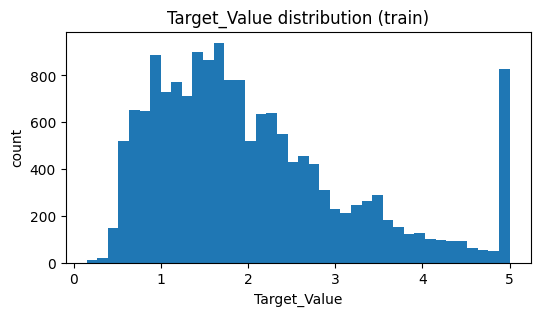

,abs_pearson_with_target
Feature_Alpha,0.325051
Feature_Gamma,0.147853
Feature_Eta,0.144372
Feature_Theta,0.045847
Feature_Delta,0.044647
Feature_Beta,0.043754
Feature_Zeta,0.021985
Feature_Epsilon,0.012592


In [8]:
# 6) Target distribution & top correlations

if TARGET_COL in train.columns:
    plt.figure(figsize=(6,3))
    plt.hist(train[TARGET_COL], bins=40)
    plt.title("Target_Value distribution (train)")
    plt.xlabel("Target_Value")
    plt.ylabel("count")
    plt.show()

# compute Pearson correlations with target (ignoring NaNs)
corrs = {}
for col in features:
    try:
        valid = train[[col, TARGET_COL]].dropna()
        if len(valid) > 10:
            cor, _ = pearsonr(valid[col], valid[TARGET_COL])
            corrs[col] = cor
    except Exception:
        corrs[col] = np.nan

corr_df = pd.Series(corrs).abs().sort_values(ascending=False).rename("abs_pearson_with_target")
display(corr_df.to_frame().head(10))


In [9]:
# 7) Distribution-shift tests between train and test for each feature
#    - median ratio (test vs train)
#    - KS two-sample test (statistic + p-value)
#    - simple bimodality detector (histogram peaks)
#    - variance ratio

def detect_feature_shift(train: pd.DataFrame, test: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    rows = []
    for col in features:
        tr_col = train[col].dropna()
        te_col = test[col].dropna() if col in test.columns else pd.Series(dtype=float)
        row = {"feature": col,
               "train_nonnull": len(tr_col),
               "test_nonnull": len(te_col),
               "train_median": tr_col.median() if len(tr_col)>0 else np.nan,
               "test_median": te_col.median() if len(te_col)>0 else np.nan,
               "train_std": tr_col.std() if len(tr_col)>0 else np.nan,
               "test_std": te_col.std() if len(te_col)>0 else np.nan}
        # median ratio (avoid division by zero)
        if not pd.isna(row["train_median"]) and row["train_median"] != 0 and not pd.isna(row["test_median"]):
            row["median_ratio_test_over_train"] = row["test_median"] / row["train_median"]
        else:
            row["median_ratio_test_over_train"] = np.nan
        # variance ratio
        if not pd.isna(row["train_std"]) and row["train_std"] > 1e-12:
            row["std_ratio_test_over_train"] = (row["test_std"] / row["train_std"]) if not pd.isna(row["test_std"]) else np.nan
        else:
            row["std_ratio_test_over_train"] = np.nan
        # KS test (only if both have enough samples)
        try:
            if len(tr_col) >= 20 and len(te_col) >= 20:
                ks_stat, ks_p = ks_2samp(tr_col, te_col)
                row["ks_stat"] = float(ks_stat)
                row["ks_pvalue"] = float(ks_p)
            else:
                row["ks_stat"] = np.nan
                row["ks_pvalue"] = np.nan
        except Exception:
            row["ks_stat"] = np.nan
            row["ks_pvalue"] = np.nan

        # simple bimodality heuristic: find peaks in histogram
        try:
            hist, edges = np.histogram(np.concatenate([tr_col.values, te_col.values]) if len(te_col)>0 else tr_col.values, bins=50)
            peaks = np.where((hist[1:-1] > hist[:-2]) & (hist[1:-1] > hist[2:]))[0]
            peaks_count = len(peaks)
            row["hist_peaks"] = peaks_count
        except Exception:
            row["hist_peaks"] = np.nan

        rows.append(row)
    return pd.DataFrame(rows).set_index("feature")

shift_df = detect_feature_shift(train, test, features)
# sort by indicators likely to show mismatch
display(shift_df.sort_values(by=["median_ratio_test_over_train"], key=lambda s: s.abs(), ascending=False).head(12))
display(shift_df.sort_values(by="ks_stat", ascending=False).head(12))


,train_nonnull,test_nonnull,train_median,test_median,train_std,test_std,median_ratio_test_over_train,std_ratio_test_over_train,ks_stat,ks_pvalue,hist_peaks
feature,,,,,,,,,,,
Feature_Epsilon,16512,4128,8.908012,163.000000,1065.591731,1070.645913,18.298135,1.004743,0.012294,0.695650,4
Feature_Zeta,16512,4128,2.815672,2.833333,11.584209,1.602358,1.006273,0.138323,0.015625,0.391699,3
Feature_Gamma,16512,4128,5.227722,5.233333,2.546012,2.163273,1.001073,0.849671,0.010780,0.833417,5
Feature_Eta,16512,4128,34.250000,34.260000,2.141151,2.115257,1.000292,0.987906,0.014595,0.478195,13
Feature_Theta,16512,4128,-118.490000,-118.520000,2.008733,1.982832,1.000253,0.987106,0.010477,0.857699,13
Feature_Beta,16512,4128,52.000000,52.000000,189.846630,190.140093,1.000000,1.001546,0.013384,0.590332,10
Feature_Delta,16512,4128,1.049367,1.046746,0.487780,0.413828,0.997502,0.848390,0.027253,0.014546,6
Feature_Alpha,16512,4128,11.156350,8.508200,22.076260,22.129534,0.762633,1.002413,0.013748,0.555804,10


,train_nonnull,test_nonnull,train_median,test_median,train_std,test_std,median_ratio_test_over_train,std_ratio_test_over_train,ks_stat,ks_pvalue,hist_peaks
feature,,,,,,,,,,,
Feature_Delta,16512,4128,1.049367,1.046746,0.487780,0.413828,0.997502,0.848390,0.027253,0.014546,6
Feature_Zeta,16512,4128,2.815672,2.833333,11.584209,1.602358,1.006273,0.138323,0.015625,0.391699,3
Feature_Eta,16512,4128,34.250000,34.260000,2.141151,2.115257,1.000292,0.987906,0.014595,0.478195,13
Feature_Alpha,16512,4128,11.156350,8.508200,22.076260,22.129534,0.762633,1.002413,0.013748,0.555804,10
Feature_Beta,16512,4128,52.000000,52.000000,189.846630,190.140093,1.000000,1.001546,0.013384,0.590332,10
Feature_Epsilon,16512,4128,8.908012,163.000000,1065.591731,1070.645913,18.298135,1.004743,0.012294,0.695650,4
Feature_Gamma,16512,4128,5.227722,5.233333,2.546012,2.163273,1.001073,0.849671,0.010780,0.833417,5
Feature_Theta,16512,4128,-118.490000,-118.520000,2.008733,1.982832,1.000253,0.987106,0.010477,0.857699,13


In [10]:
# 8) Flag features that probably need "unit alignment" or special preprocessing
#    Criteria (heuristic):
#      - median_ratio_test_over_train magnitude > 3  (test medians very different)
#      - OR ks_stat > 0.2 (large distributional change)
#      - OR hist_peaks >= 2 (possible bimodality)
#      - OR test_nonnull is much smaller than train_nonnull (missingness)

def flag_features_for_attention(shift_df: pd.DataFrame, ratio_thresh: float = 3.0, ks_thresh: float = 0.2) -> pd.Series:
    flags = []
    for idx, r in shift_df.iterrows():
        f = False
        reasons = []
        mr = r.get("median_ratio_test_over_train", np.nan)
        if (not pd.isna(mr)) and (abs(mr) > ratio_thresh):
            f = True
            reasons.append(f"median_ratio={mr:.2f}")
        if (not pd.isna(r.get("ks_stat"))) and (r.get("ks_stat") > ks_thresh):
            f = True
            reasons.append(f"ks_stat={r.get('ks_stat'):.3f}")
        if (not pd.isna(r.get("hist_peaks"))) and (r.get("hist_peaks") >= 2):
            f = True
            reasons.append(f"hist_peaks={int(r.get('hist_peaks'))}")
        if r.get("test_nonnull", 0) < 0.2 * r.get("train_nonnull", 1):
            f = True
            reasons.append(f"missing_in_test ({int(r.get('test_nonnull'))}/{int(r.get('train_nonnull'))})")
        flags.append({"feature": idx, "flagged": f, "reasons": "; ".join(reasons)})
    return pd.DataFrame(flags).set_index("feature")

flags = flag_features_for_attention(shift_df)
display(flags[flags["flagged"]])

,flagged,reasons
feature,,
Feature_Alpha,True,hist_peaks=10
Feature_Beta,True,hist_peaks=10
Feature_Gamma,True,hist_peaks=5
Feature_Delta,True,hist_peaks=6
Feature_Epsilon,True,median_ratio=18.30; hist_peaks=4
Feature_Zeta,True,hist_peaks=3
Feature_Eta,True,hist_peaks=13
Feature_Theta,True,hist_peaks=13


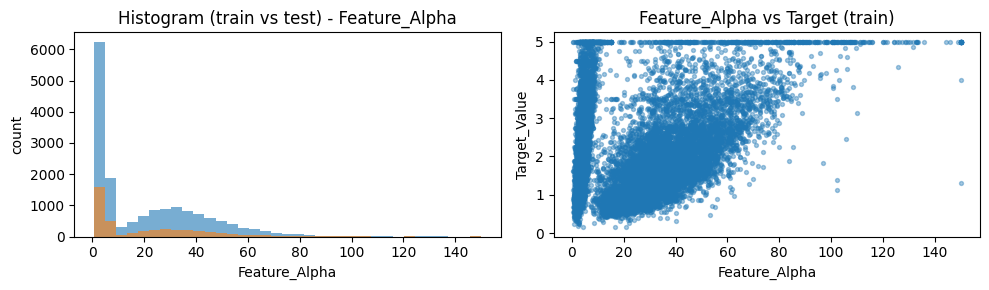

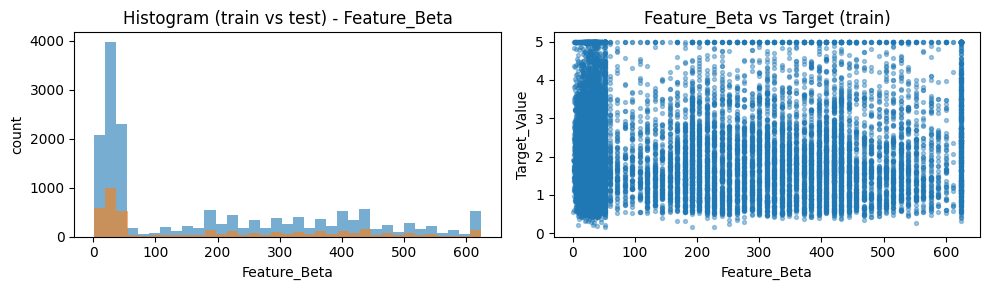

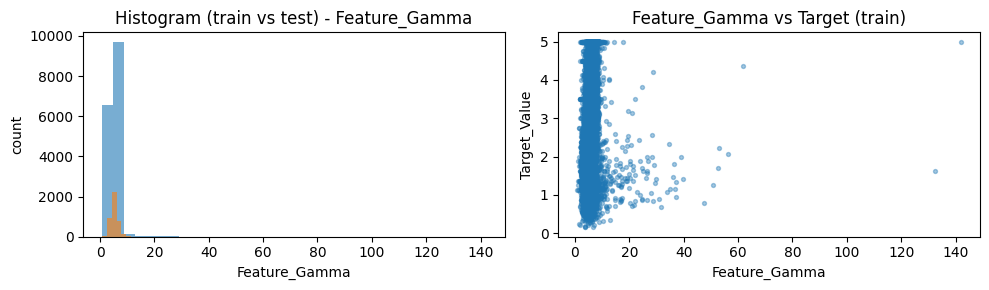

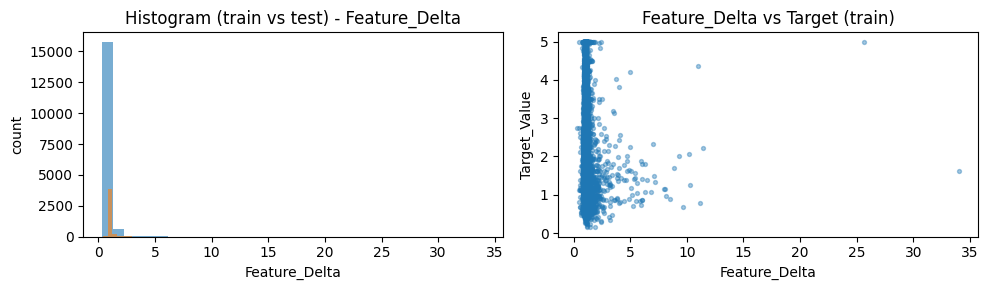

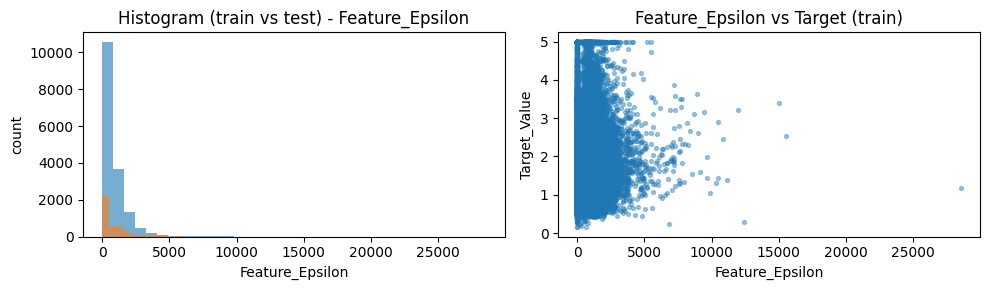

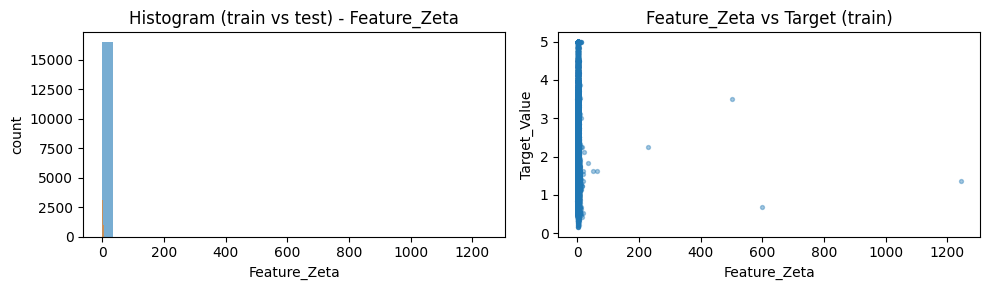

In [11]:
# 9) Visual quick-plots for flagged features (up to 6)

flagged = list(flags[flags["flagged"]].index)[:6]
if flagged:
    for col in flagged:
        plt.figure(figsize=(10,3))
        # overlay train and test histograms
        a = train[col].dropna()
        b = test[col].dropna() if col in test.columns else pd.Series(dtype=float)
        plt.subplot(1,2,1)
        plt.hist(a, bins=35, alpha=0.6)
        if len(b) > 0:
            plt.hist(b, bins=35, alpha=0.6)
        plt.title(f"Histogram (train vs test) - {col}")
        plt.xlabel(col)
        plt.ylabel("count")
        # scatter vs target (train only)
        plt.subplot(1,2,2)
        if TARGET_COL in train.columns:
            plt.scatter(a, train.loc[a.index, TARGET_COL], alpha=0.4, s=8)
            plt.title(f"{col} vs Target (train)")
            plt.xlabel(col)
            plt.ylabel("Target_Value")
        plt.tight_layout()
        plt.show()
else:
    print("No features flagged by heuristics. Still inspect features manually.")

In [12]:
# 10) Save the shift summary for later steps (CSV)

shift_df.to_csv("feature_shift_summary.csv")
flags.to_csv("feature_shift_flags.csv")
print("Saved: feature_shift_summary.csv, feature_shift_flags.csv")

Saved: feature_shift_summary.csv, feature_shift_flags.csv


# Notebook Block 2: Preprocessing pipeline -- unit alignment, bimodal handling, imputing, transforms, scaling

In [13]:
import os
import numpy as np
import pandas as pd
from typing import List, Dict

# sklearn utilities
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from scipy.stats import ks_2samp
import joblib    # reliable joblib
import warnings
warnings.filterwarnings("ignore")


# CONFIG / PATHS (adjust if needed)
TRAIN_PATH = "/kaggle/input/applai-26-nn-competition/train.csv"
TEST_PATH  = "/kaggle/input/applai-26-nn-competition/test.csv"
SHIFT_SUMMARY_CSV = "feature_shift_summary.csv"   # produced by Block 1
FLAGS_CSV = "feature_shift_flags.csv"             # produced by Block 1
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

ID_COL = "ID"
TARGET_COL = "Target_Value"

# thresholds (tweakable)
UNIT_RATIO_THRESHOLD = 3.0   # used by UnitAligner to decide alignment
MIN_SAMPLES_FOR_ALIGN = 30   # min samples to attempt fitting GMM for a col
MIN_SAMPLES_FOR_KMEANS = 30  # min samples to attempt KMeans for a col
CLIP_LOW, CLIP_HIGH = 0.01, 0.99

In [14]:
# 0) Load data and saved detection CSVs from Block 1

assert os.path.exists(TRAIN_PATH), f"train file not found: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"test file not found: {TEST_PATH}"
assert os.path.exists(SHIFT_SUMMARY_CSV), f"shift summary CSV missing: {SHIFT_SUMMARY_CSV}"
assert os.path.exists(FLAGS_CSV), f"flags CSV missing: {FLAGS_CSV}"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
shift_df = pd.read_csv(SHIFT_SUMMARY_CSV, index_col=0)
flags_df = pd.read_csv(FLAGS_CSV, index_col=0)

features = [c for c in train.columns if c not in (ID_COL, TARGET_COL)]
print("Loaded data. Features:", features)


Loaded data. Features: ['Feature_Alpha', 'Feature_Beta', 'Feature_Gamma', 'Feature_Delta', 'Feature_Epsilon', 'Feature_Zeta', 'Feature_Eta', 'Feature_Theta']


In [15]:
# 1) Decide which columns need special handling based on Block 1 flags (no re-detection)
#    - bimodal_cols: those flagged with hist_peaks >= 2 (or reasons contains 'hist_peaks')
#    - align_candidate_cols: those flagged with median_ratio or large median_ratio in shift_df
# use flags_df.reasons if available
bimodal_cols = []
align_candidate_cols = []

# parse reasons safely (some rows may have NaN)
for feat in features:
    reasons = ""
    if feat in flags_df.index:
        reasons = str(flags_df.loc[feat, "reasons"])
    # bimodal if reason mentions hist_peaks or if shift_df hist_peaks >= 2
    if ("hist_peaks" in reasons and ("=" in reasons or reasons.count("hist_peaks")>0)) or \
       (feat in shift_df.index and not np.isnan(shift_df.loc[feat, "hist_peaks"]) and shift_df.loc[feat, "hist_peaks"] >= 2):
        bimodal_cols.append(feat)
    # align candidates if reason has median_ratio OR shift_df shows big ratio
    mr = shift_df.loc[feat, "median_ratio_test_over_train"] if (feat in shift_df.index) else np.nan
    if ("median_ratio" in reasons) or (not pd.isna(mr) and abs(mr) > UNIT_RATIO_THRESHOLD):
        align_candidate_cols.append(feat)

# fallback if lists empty: be conservative - try aligning only features with large median ratio in shift_df
if len(align_candidate_cols) == 0:
    align_candidate_cols = [f for f in features if (f in shift_df.index and not pd.isna(shift_df.loc[f,"median_ratio_test_over_train"]) and abs(shift_df.loc[f,"median_ratio_test_over_train"])>UNIT_RATIO_THRESHOLD)]

print("Bimodal columns (selected):", bimodal_cols)
print("Align-candidate columns (selected):", align_candidate_cols)

Bimodal columns (selected): ['Feature_Alpha', 'Feature_Beta', 'Feature_Gamma', 'Feature_Delta', 'Feature_Epsilon', 'Feature_Zeta', 'Feature_Eta', 'Feature_Theta']
Align-candidate columns (selected): ['Feature_Epsilon']


In [16]:
# 2) Custom Transformers (lightweight versions)
#    UnitAligner: fits GMM(2) on selected cols and scales values in larger-mean cluster by ratio
#    BimodalSplitter: fits KMeans(2) on selected cols and produces <col>__mode indicator
#    Clipper: compute train percentiles and clip

class UnitAligner(BaseEstimator, TransformerMixin):
    def __init__(self, columns: List[str], ratio_thresh: float = UNIT_RATIO_THRESHOLD, min_samples:int=MIN_SAMPLES_FOR_ALIGN, random_state: int = 42):
        self.columns = columns
        self.ratio_thresh = ratio_thresh
        self.min_samples = min_samples
        self.random_state = random_state
        self.params_ = {}

    def fit(self, X, y=None):
        # X is expected DataFrame with columns containing numeric columns
        for col in self.columns:
            col_vals = X[col].dropna().values.reshape(-1,1)
            if len(col_vals) < self.min_samples:
                self.params_[col] = {"align": False}
                continue
            try:
                gmm = GaussianMixture(n_components=2, random_state=self.random_state)
                gmm.fit(col_vals)
                means = gmm.means_.ravel()
                low, high = np.sort(means)[0], np.sort(means)[1]
                if low <= 0:
                    ratio = np.inf
                else:
                    ratio = high / low
                if ratio > self.ratio_thresh and low > 0:
                    # align: scale down values in cluster with higher mean
                    higher_idx = int(np.argmax(means))
                    self.params_[col] = {"align": True, "gmm": gmm, "scale_ratio": float(ratio), "higher_idx": higher_idx}
                else:
                    self.params_[col] = {"align": False, "gmm": gmm, "scale_ratio": float(ratio)}
            except Exception:
                self.params_[col] = {"align": False}
        return self

    def transform(self, X):
        X = X.copy()
        for col, p in self.params_.items():
            if not p.get("align", False):
                continue
            nonnull = X[col].notna()
            if nonnull.sum() == 0:
                continue
            vals = X.loc[nonnull, col].values.reshape(-1,1)
            labels = p["gmm"].predict(vals)
            mask = (labels == p["higher_idx"])
            scaled_vals = vals.astype(float)
            scaled_vals[mask] = scaled_vals[mask] / p["scale_ratio"]
            X.loc[nonnull, col] = scaled_vals.ravel()
        return X

class BimodalSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, columns: List[str], min_samples: int = MIN_SAMPLES_FOR_KMEANS):
        self.columns = columns
        self.min_samples = min_samples
        self.km_map = {}

    def fit(self, X, y=None):
        for col in self.columns:
            vals = X[col].dropna().values.reshape(-1,1)
            if len(vals) < self.min_samples:
                self.km_map[col] = None
                continue
            try:
                km = KMeans(n_clusters=2, random_state=42).fit(vals)
                self.km_map[col] = km
            except Exception:
                self.km_map[col] = None
        return self

    def transform(self, X):
        Xout = X.copy()
        for col, km in self.km_map.items():
            indicator_name = f"{col}__mode"
            if km is None:
                Xout[indicator_name] = 0
                continue
            nonnull = Xout[col].notna()
            if nonnull.sum() == 0:
                Xout[indicator_name] = 0
                continue
            labels = km.predict(Xout.loc[nonnull, col].values.reshape(-1,1))
            centers = km.cluster_centers_.ravel()
            larger_cluster = int(np.argmax(centers))
            idx_vec = np.zeros(len(Xout), dtype=int)
            idx_vec[nonnull.index] = (labels == larger_cluster).astype(int)
            Xout[indicator_name] = idx_vec
        return Xout

class Clipper(BaseEstimator, TransformerMixin):
    def __init__(self, cols: List[str], low=CLIP_LOW, high=CLIP_HIGH):
        self.cols = cols
        self.low = low
        self.high = high
        self.lo = {}
        self.hi = {}

    def fit(self, X, y=None):
        for c in self.cols:
            arr = X[c].dropna().values
            if arr.size == 0:
                self.lo[c] = -np.inf
                self.hi[c] = np.inf
            else:
                self.lo[c] = np.quantile(arr, self.low)
                self.hi[c] = np.quantile(arr, self.high)
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[c] = X[c].clip(self.lo.get(c, -np.inf), self.hi.get(c, np.inf))
        return X


In [17]:
# 3) Build & fit the pipeline (streamlined)
#    Steps:
#      A) UnitAligner.fit on align_candidate_cols (only) -> transform entire numeric frame
#      B) BimodalSplitter.fit on bimodal_cols -> transform to add indicators
#      C) Imputer (median) on numeric+indicators -> transform
#      D) Optional log1p on skewed (compute quick skews here)
#      E) Clipper.fit -> transform
#      F) RobustScaler.fit -> transform
# -----------------------------------------------------------------------------------------

# A) Unit alignment: fit only on selected align_candidate_cols to save time.
ua = UnitAligner(columns=align_candidate_cols, ratio_thresh=UNIT_RATIO_THRESHOLD, min_samples=MIN_SAMPLES_FOR_ALIGN)
# But UnitAligner expects DataFrame with those columns; we'll fit then use it to transform full numeric frame.
ua.fit(train[align_candidate_cols] if len(align_candidate_cols)>0 else train[features])

# Transform train numeric columns with alignment (we keep all features; ua will only affect selected columns)
train_aligned = train[features].copy()
if len(align_candidate_cols) > 0:
    aligned_part = ua.transform(train[align_candidate_cols])
    train_aligned.loc[:, align_candidate_cols] = aligned_part.loc[:, align_candidate_cols]

# B) Bimodal splitter: fit only for selected bimodal columns
bsplit = BimodalSplitter(columns=bimodal_cols, min_samples=MIN_SAMPLES_FOR_KMEANS)
# note: pass the aligned columns for the bimodal columns to be consistent
if len(bimodal_cols) > 0:
    bsplit.fit(train_aligned[bimodal_cols])
# transform (adds indicator columns)
train_split = bsplit.transform(train_aligned)

# Prepare final column list (original numeric + new indicators)
indicator_cols = [f"{c}__mode" for c in bimodal_cols]
final_cols = features + indicator_cols

# C) Imputer (median)
imputer = SimpleImputer(strategy="median")
imputer.fit(train_split[final_cols])
train_imputed = pd.DataFrame(imputer.transform(train_split[final_cols]), columns=final_cols)

# D) quick skew detection to decide log1p (cheap)
skews = train_imputed.skew().abs().sort_values(ascending=False)
log_cols = skews[skews > 1.0].index.tolist()   # threshold = 1.0, tweak if desired
# apply log1p only to non-negative columns (safe)
for c in log_cols:
    if (train_imputed[c] >= 0).all():
        train_imputed[c] = np.log1p(train_imputed[c])

# E) clip extremes
clipper = Clipper(cols=final_cols, low=CLIP_LOW, high=CLIP_HIGH)
clipper.fit(train_imputed)
train_clipped = clipper.transform(train_imputed)

# F) scaler (RobustScaler)
scaler = RobustScaler()
scaler.fit(train_clipped)
train_scaled = pd.DataFrame(scaler.transform(train_clipped), columns=final_cols)


In [18]:
# 4) Apply same transforms to test (in the same lightweight order)
# -------------------------
# Align on test: only apply to align_candidate_cols
test_aligned = test[features].copy()
if len(align_candidate_cols) > 0:
    test_aligned.loc[:, align_candidate_cols] = ua.transform(test[align_candidate_cols]).loc[:, align_candidate_cols]

# Bimodal split on test -> add indicators
test_split = bsplit.transform(test_aligned)

# Impute test
test_imputed = pd.DataFrame(imputer.transform(test_split[final_cols]), columns=final_cols)

# log1p on same log_cols
for c in log_cols:
    if (test_imputed[c] >= 0).all():
        test_imputed[c] = np.log1p(test_imputed[c])

# clip and scale
test_clipped = clipper.transform(test_imputed)
test_scaled = pd.DataFrame(scaler.transform(test_clipped), columns=final_cols)


In [19]:
# 5) Diagnostics: compact before/after shift summary for the treated columns
#    We'll compute median_ratio and KS-stat for each final col (before = raw train/test, after = post-processed train/test)

def shift_summary_before_after(train_df_raw, test_df_raw, train_after_df, test_after_df, cols):
    rows = []
    for c in cols:
        tr_raw = train_df_raw[c].dropna() if c in train_df_raw.columns else pd.Series(dtype=float)
        te_raw = test_df_raw[c].dropna() if c in test_df_raw.columns else pd.Series(dtype=float)
        tr_a = train_after_df[c].dropna() if c in train_after_df.columns else pd.Series(dtype=float)
        te_a = test_after_df[c].dropna() if c in test_after_df.columns else pd.Series(dtype=float)
        row = {"feature": c,
               "train_median_before": np.nan if tr_raw.size==0 else np.median(tr_raw),
               "test_median_before": np.nan if te_raw.size==0 else np.median(te_raw),
               "train_median_after": np.nan if tr_a.size==0 else np.median(tr_a),
               "test_median_after": np.nan if te_a.size==0 else np.median(te_a)}
        # ks
        try:
            if tr_raw.size>=20 and te_raw.size>=20:
                ks_b, p_b = ks_2samp(tr_raw, te_raw)
            else:
                ks_b = np.nan
            if tr_a.size>=20 and te_a.size>=20:
                ks_a, p_a = ks_2samp(tr_a, te_a)
            else:
                ks_a = np.nan
            row["ks_before"] = ks_b
            row["ks_after"] = ks_a
        except Exception:
            row["ks_before"] = np.nan
            row["ks_after"] = np.nan
        rows.append(row)
    return pd.DataFrame(rows).set_index("feature")

# For 'before' we will use the raw features for original columns; for 'after' use train_scaled/test_scaled
# For indicators (new columns) we compute medians/ks on imputed before scaling (test_imputed/train_imputed)
before_after_cols = final_cols  # includes indicators
shift_comparison = shift_summary_before_after(train[features], test[features], train_scaled, test_scaled, before_after_cols)
display(shift_comparison.sort_values(by="ks_before", ascending=False).head(12))

,train_median_before,test_median_before,train_median_after,test_median_after,ks_before,ks_after
feature,,,,,,
Feature_Delta,1.049367,1.046746,0.0,-0.028099,0.027253,0.027253
Feature_Zeta,2.815672,2.833333,0.0,0.020798,0.015625,0.015625
Feature_Eta,34.250000,34.260000,0.0,0.002639,0.014595,0.014595
Feature_Alpha,11.156350,8.508200,0.0,-0.118229,0.013748,0.013748
Feature_Beta,52.000000,52.000000,0.0,0.000000,0.013384,0.013384
Feature_Epsilon,8.908012,163.000000,0.0,-0.012169,0.012294,0.014535
Feature_Gamma,5.227722,5.233333,0.0,0.003483,0.010780,0.010780
Feature_Theta,-118.490000,-118.520000,0.0,-0.007916,0.010477,0.010477
Feature_Alpha__mode,NaN,NaN,0.0,0.000000,NaN,0.007812


In [20]:
# 6) Save artifacts (fitted objects + processed previews)

fitted = {
    "unit_aligner": ua,
    "bimodal_splitter": bsplit,
    "imputer": imputer,
    "clipper": clipper,
    "scaler": scaler,
    "final_cols": final_cols,
    "indicator_cols": indicator_cols,
    "log_cols": log_cols,
    "align_candidate_cols": align_candidate_cols,
    "bimodal_cols": bimodal_cols
}
joblib.dump(fitted, os.path.join(ARTIFACT_DIR, "preprocessing_pipeline.joblib"))
train_scaled.to_csv(os.path.join(ARTIFACT_DIR, "X_train_processed.csv"), index=False)
test_scaled.to_csv(os.path.join(ARTIFACT_DIR, "X_test_processed.csv"), index=False)
print("Saved fitted pipeline and processed previews to", ARTIFACT_DIR)


Saved fitted pipeline and processed previews to artifacts


# Notebook Block 3: Neural network training (K-fold CV) + ensembling + final submission

In [21]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt

# reproducibility helpers
def set_seed(seed=42):
    import os, random
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    try:
        import tensorflow as _tf
        _tf.random.set_seed(seed)
    except Exception:
        pass

set_seed(42)

# Paths (adjust if needed)
ARTIFACT_DIR = "artifacts"
PIPELINE_JOBLIB = os.path.join(ARTIFACT_DIR, "preprocessing_pipeline.joblib")
X_TRAIN_PROC_CSV = os.path.join(ARTIFACT_DIR, "X_train_processed.csv")
X_TEST_PROC_CSV  = os.path.join(ARTIFACT_DIR, "X_test_processed.csv")
RAW_TRAIN_PATH = "/kaggle/input/applai-26-nn-competition/train.csv"
RAW_TEST_PATH  = "/kaggle/input/applai-26-nn-competition/test.csv"

# Load raw data (for IDs & target)
train_raw = pd.read_csv(RAW_TRAIN_PATH)
test_raw  = pd.read_csv(RAW_TEST_PATH)
ID_COL = "ID"
TARGET_COL = "Target_Value"

2025-12-28 18:28:36.263982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766946516.460005      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766946516.514522      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766946516.983648      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766946516.983687      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766946516.983690      55 computation_placer.cc:177] computation placer alr

In [22]:
# 1) Load processed features 

if os.path.exists(X_TRAIN_PROC_CSV) and os.path.exists(X_TEST_PROC_CSV):
    X_train_proc = pd.read_csv(X_TRAIN_PROC_CSV)
    X_test_proc  = pd.read_csv(X_TEST_PROC_CSV)
    print("Loaded processed CSVs from artifacts.")
else:
    # try to load pipeline and apply it (defensive)
    assert os.path.exists(PIPELINE_JOBLIB), "No processed CSVs and no pipeline joblib found. Run Block 2 first."
    fitted = joblib.load(PIPELINE_JOBLIB)
    # apply fitted pipeline objects to raw frames to create processed arrays
    # we expect fitted to contain keys: unit_aligner, bimodal_splitter, imputer, clipper, scaler, final_cols, log_cols
    ua = fitted["unit_aligner"]
    bsplit = fitted["bimodal_splitter"]
    imputer = fitted["imputer"]
    clipper = fitted["clipper"]
    scaler = fitted["scaler"]
    final_cols = fitted["final_cols"]
    log_cols = fitted.get("log_cols", [])
    # apply same transforms:
    X_raw = train_raw[[c for c in train_raw.columns if c not in (ID_COL, TARGET_COL)]].copy()
    X_test_raw = test_raw[[c for c in test_raw.columns if c not in (ID_COL, )]].copy()
    # unit align
    try:
        X_raw_al = ua.transform(X_raw)
        X_test_al = ua.transform(X_test_raw)
    except Exception:
        X_raw_al = X_raw.copy()
        X_test_al = X_test_raw.copy()
    # bimodal
    X_raw_split = bsplit.transform(X_raw_al)
    X_test_split = bsplit.transform(X_test_al)
    # impute
    X_train_proc = pd.DataFrame(imputer.transform(X_raw_split[final_cols]), columns=final_cols)
    X_test_proc  = pd.DataFrame(imputer.transform(X_test_split[final_cols]), columns=final_cols)
    # log transform
    for c in log_cols:
        if (X_train_proc[c] >= 0).all():
            X_train_proc[c] = np.log1p(X_train_proc[c])
            X_test_proc[c]  = np.log1p(X_test_proc[c])
    # clip
    X_train_proc = clipper.transform(X_train_proc)
    X_test_proc  = clipper.transform(X_test_proc)
    # scale
    X_train_proc = pd.DataFrame(scaler.transform(X_train_proc), columns=final_cols)
    X_test_proc  = pd.DataFrame(scaler.transform(X_test_proc), columns=final_cols)
    print("Applied fitted pipeline to raw data to create processed sets.")

# Targets and IDs
y = train_raw[TARGET_COL].values
train_ids = train_raw[ID_COL].values
test_ids  = test_raw[ID_COL].values

print("X_train_proc shape:", X_train_proc.shape)
print("X_test_proc shape:", X_test_proc.shape)


Loaded processed CSVs from artifacts.
X_train_proc shape: (16512, 16)
X_test_proc shape: (4128, 16)


In [23]:
# 2) Model building utilities 

def build_keras_model(input_dim, hidden_units=(128,64), dropout=0.15, lr=1e-3):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam

    model = Sequential()
    model.add(Dense(hidden_units[0], activation="relu", input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(hidden_units[1], activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout/2))
    model.add(Dense(1, activation="linear"))
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mse"])
    return model

In [24]:
# Try to import tensorflow, else fallback to sklearn MLP
USE_TF = True
try:
    import tensorflow as tf
    # check GPU availability (optional)
    print("TensorFlow version:", tf.__version__)
except Exception as e:
    print("TensorFlow not available. Will use sklearn MLPRegressor fallback.")
    USE_TF = False

TensorFlow version: 2.19.0



--- Fold 1/5 ---


I0000 00:00:1766946529.312664      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766946529.316688      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/200


I0000 00:00:1766946532.372623     133 service.cc:152] XLA service 0x7fd0c80083c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766946532.372680     133 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766946532.372684     133 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766946532.723774     133 cuda_dnn.cc:529] Loaded cuDNN version 91002


 71/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6034 - mse: 5.6034

I0000 00:00:1766946534.554834     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1504 - mse: 4.1504

207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 4.1431 - mse: 4.1431 - val_loss: 0.8333 - val_mse: 0.8333 - learning_rate: 0.0010
Epoch 2/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8901 - mse: 0.8901

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8863 - mse: 0.8863 - val_loss: 0.5738 - val_mse: 0.5738 - learning_rate: 0.0010
Epoch 3/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7304 - mse: 0.7304

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7287 - mse: 0.7287 - val_loss: 0.4607 - val_mse: 0.4607 - learning_rate: 0.0010
Epoch 4/200
204/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6413 - mse: 0.6413

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6409 - mse: 0.6409 - val_loss: 0.4305 - val_mse: 0.4305 - learning_rate: 0.0010
Epoch 5/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5904 - mse: 0.5904

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5888 - mse: 0.5888 - val_loss: 0.4037 - val_mse: 0.4037 - learning_rate: 0.0010
Epoch 6/200
185/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5506 - mse: 0.5506

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5490 - mse: 0.5490 - val_loss: 0.3968 - val_mse: 0.3968 - learning_rate: 0.0010
Epoch 7/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4947 - mse: 0.4947

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4940 - mse: 0.4940 - val_loss: 0.3827 - val_mse: 0.3827 - learning_rate: 0.0010
Epoch 8/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4820 - mse: 0.4820

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4809 - mse: 0.4809 - val_loss: 0.3822 - val_mse: 0.3822 - learning_rate: 0.0010
Epoch 9/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4702 - mse: 0.4702

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4686 - mse: 0.4686 - val_loss: 0.3687 - val_mse: 0.3687 - learning_rate: 0.0010
Epoch 10/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4608 - mse: 0.4608

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4596 - mse: 0.4596 - val_loss: 0.3543 - val_mse: 0.3543 - learning_rate: 0.0010
Epoch 11/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4406 - mse: 0.4406

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4398 - mse: 0.4398 - val_loss: 0.3497 - val_mse: 0.3497 - learning_rate: 0.0010
Epoch 12/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4350 - mse: 0.4350 - val_loss: 0.3497 - val_mse: 0.3497 - learning_rate: 0.0010
Epoch 13/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4151 - mse: 0.4151

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4143 - mse: 0.4143 - val_loss: 0.3442 - val_mse: 0.3442 - learning_rate: 0.0010
Epoch 14/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4087 - mse: 0.4087

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4080 - mse: 0.4080 - val_loss: 0.3372 - val_mse: 0.3372 - learning_rate: 0.0010
Epoch 15/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3979 - mse: 0.3979 - val_loss: 0.3426 - val_mse: 0.3426 - learning_rate: 0.0010
Epoch 16/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4005 - mse: 0.4005 - val_loss: 0.3381 - val_mse: 0.3381 - learning_rate: 0.0010
Epoch 17/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3850 - mse: 0.3850

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3845 - mse: 0.3845 - val_loss: 0.3272 - val_mse: 0.3272 - learning_rate: 0.0010
Epoch 18/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3914 - mse: 0.3914 - val_loss: 0.3292 - val_mse: 0.3292 - learning_rate: 0.0010
Epoch 19/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3846 - mse: 0.3846 - val_loss: 0.3289 - val_mse: 0.3289 - learning_rate: 0.0010
Epoch 20/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3841 - mse: 0.3841

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3831 - mse: 0.3831 - val_loss: 0.3231 - val_mse: 0.3231 - learning_rate: 0.0010
Epoch 21/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3739 - mse: 0.3739

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3729 - mse: 0.3729 - val_loss: 0.3224 - val_mse: 0.3224 - learning_rate: 0.0010
Epoch 22/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3646 - mse: 0.3646 - val_loss: 0.3238 - val_mse: 0.3238 - learning_rate: 0.0010
Epoch 23/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3709 - mse: 0.3709 - val_loss: 0.3285 - val_mse: 0.3285 - learning_rate: 0.0010
Epoch 24/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3609 - mse: 0.3609

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3603 - mse: 0.3603 - val_loss: 0.3198 - val_mse: 0.3198 - learning_rate: 0.0010
Epoch 25/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3618 - mse: 0.3618 - val_loss: 0.3216 - val_mse: 0.3216 - learning_rate: 0.0010
Epoch 26/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3597 - mse: 0.3597 - val_loss: 0.3213 - val_mse: 0.3213 - learning_rate: 0.0010
Epoch 27/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3634 - mse: 0.3634

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3625 - mse: 0.3625 - val_loss: 0.3164 - val_mse: 0.3164 - learning_rate: 0.0010
Epoch 28/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3564 - mse: 0.3564 - val_loss: 0.3177 - val_mse: 0.3177 - learning_rate: 0.0010
Epoch 29/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3493 - mse: 0.3493 - val_loss: 0.3192 - val_mse: 0.3192 - learning_rate: 0.0010
Epoch 30/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3497 - mse: 0.3497 - val_loss: 0.3198 - val_mse: 0.3198 - learning_rate: 0.0010
Epoch 31/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3492 - mse: 0.3492

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3483 - mse: 0.3483 - val_loss: 0.3158 - val_mse: 0.3158 - learning_rate: 0.0010
Epoch 32/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3480 - mse: 0.3480 - val_loss: 0.3163 - val_mse: 0.3163 - learning_rate: 0.0010
Epoch 33/200
185/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3495 - mse: 0.3495

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3481 - mse: 0.3481 - val_loss: 0.3119 - val_mse: 0.3119 - learning_rate: 0.0010
Epoch 34/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3418 - mse: 0.3418 - val_loss: 0.3123 - val_mse: 0.3123 - learning_rate: 0.0010
Epoch 35/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3375 - mse: 0.3375 - val_loss: 0.3141 - val_mse: 0.3141 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3393 - mse: 0.3393 - val_loss: 0.3156 - val_mse: 0.3156 - learning_rate: 0.0010
Epoch 37/200
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3396 - mse: 0.3396

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3395 - mse: 0.3395 - val_loss: 0.3106 - val_mse: 0.3106 - learning_rate: 0.0010
Epoch 38/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3406 - mse: 0.3406 - val_loss: 0.3154 - val_mse: 0.3154 - learning_rate: 0.0010
Epoch 39/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3349 - mse: 0.3349

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3341 - mse: 0.3341 - val_loss: 0.3101 - val_mse: 0.3101 - learning_rate: 0.0010
Epoch 40/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3307 - mse: 0.3307 - val_loss: 0.3144 - val_mse: 0.3144 - learning_rate: 0.0010
Epoch 41/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3329 - mse: 0.3329

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3324 - mse: 0.3324 - val_loss: 0.3094 - val_mse: 0.3094 - learning_rate: 0.0010
Epoch 42/200
196/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3334 - mse: 0.3334

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3327 - mse: 0.3327 - val_loss: 0.3084 - val_mse: 0.3084 - learning_rate: 0.0010
Epoch 43/200
199/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3325 - mse: 0.3325

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3320 - mse: 0.3320 - val_loss: 0.3083 - val_mse: 0.3083 - learning_rate: 0.0010
Epoch 44/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3232 - mse: 0.3232 - val_loss: 0.3103 - val_mse: 0.3103 - learning_rate: 0.0010
Epoch 45/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3241 - mse: 0.3241 - val_loss: 0.3113 - val_mse: 0.3113 - learning_rate: 0.0010
Epoch 46/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3278 - mse: 0.3278 - val_loss: 0.3133 - val_mse: 0.3133 - learning_rate: 0.0010
Epoch 47/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3236 - mse: 0.3236 - val_loss: 0.3102 - val_mse: 0.3102 - learning_rate: 0.0010
Epoch 48/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3249 - mse: 0.3249

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3244 - mse: 0.3244 - val_loss: 0.3067 - val_mse: 0.3067 - learning_rate: 0.0010
Epoch 49/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3204 - mse: 0.3204 - val_loss: 0.3088 - val_mse: 0.3088 - learning_rate: 0.0010
Epoch 50/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3200 - mse: 0.3200 - val_loss: 0.3106 - val_mse: 0.3106 - learning_rate: 0.0010
Epoch 51/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3132 - mse: 0.3132 - val_loss: 0.3122 - val_mse: 0.3122 - learning_rate: 0.0010
Epoch 52/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3175 - mse: 0.3175 - val_loss: 0.3112 - val_mse: 0.3112 - learning_rate: 0.0010
Epoch 53/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3170 - mse: 0.3170 - val_loss: 0.3127 - val_mse: 0.3127 - learning_rate: 0.0010
Epoch 54/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3166 - mse: 0.3166

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3159 - mse: 0.3159 - val_loss: 0.3039 - val_mse: 0.3039 - learning_rate: 0.0010
Epoch 55/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3118 - mse: 0.3118 - val_loss: 0.3111 - val_mse: 0.3111 - learning_rate: 0.0010
Epoch 56/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3144 - mse: 0.3144 - val_loss: 0.3056 - val_mse: 0.3056 - learning_rate: 0.0010
Epoch 57/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3122 - mse: 0.3122 - val_loss: 0.3065 - val_mse: 0.3065 - learning_rate: 0.0010
Epoch 58/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3086 - mse: 0.3086 - val_loss: 0.3077 - val_mse: 0.3077 - learning_rate: 0.0010
Epoch 59/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3150 - mse: 0.3150

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3142 - mse: 0.3142 - val_loss: 0.3034 - val_mse: 0.3034 - learning_rate: 0.0010
Epoch 60/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3093 - mse: 0.3093 - val_loss: 0.3073 - val_mse: 0.3073 - learning_rate: 0.0010
Epoch 61/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3071 - mse: 0.3071 - val_loss: 0.3106 - val_mse: 0.3106 - learning_rate: 0.0010
Epoch 62/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3100 - mse: 0.3100

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3094 - mse: 0.3094 - val_loss: 0.3012 - val_mse: 0.3012 - learning_rate: 0.0010
Epoch 63/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3105 - mse: 0.3105 - val_loss: 0.3088 - val_mse: 0.3088 - learning_rate: 0.0010
Epoch 64/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3023 - mse: 0.3023 - val_loss: 0.3065 - val_mse: 0.3065 - learning_rate: 0.0010
Epoch 65/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3120 - mse: 0.3120 - val_loss: 0.3074 - val_mse: 0.3074 - learning_rate: 0.0010
Epoch 66/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3027 - mse: 0.3027 - val_loss: 0.3048 - val_mse: 0.3048 - learning_rate: 0.0010
Epoch 67/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3001 - mse: 0.3001 - val_loss: 0.3043 - val_mse: 0.3043 - learning_rate: 0.0010
Epoch 68/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3026 - mse: 0.3026

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3025 - mse: 0.3025 - val_loss: 0.2995 - val_mse: 0.2995 - learning_rate: 0.0010
Epoch 69/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3089 - mse: 0.3089 - val_loss: 0.2999 - val_mse: 0.2999 - learning_rate: 0.0010
Epoch 70/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2960 - mse: 0.2960 - val_loss: 0.3053 - val_mse: 0.3053 - learning_rate: 0.0010
Epoch 71/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3032 - mse: 0.3032 - val_loss: 0.3104 - val_mse: 0.3104 - learning_rate: 0.0010
Epoch 72/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3015 - mse: 0.3015 - val_loss: 0.3081 - val_mse: 0.3081 - learning_rate: 0.0010
Epoch 73/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2987 - mse: 0.2987 - val_loss: 0.3026 - val_mse: 0.3026 - learning_rate: 0.0010
Epoch 74/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2953 - mse: 0.2953 - val_loss: 0.3139 - val_mse: 0.3139 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2903 - mse: 0.2903 - val_loss: 0.2978 - val_mse: 0.2978 - learning_rate: 5.0000e-04
Epoch 77/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2817 - mse: 0.2817 - val_loss: 0.3005 - val_mse: 0.3005 - learning_rate: 5.0000e-04
Epoch 78/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2892 - mse: 0.2892

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2883 - mse: 0.2883 - val_loss: 0.2961 - val_mse: 0.2961 - learning_rate: 5.0000e-04
Epoch 79/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2860 - mse: 0.2860 - val_loss: 0.2961 - val_mse: 0.2961 - learning_rate: 5.0000e-04
Epoch 80/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2869 - mse: 0.2869 - val_loss: 0.2986 - val_mse: 0.2986 - learning_rate: 5.0000e-04
Epoch 81/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2807 - mse: 0.2807 - val_loss: 0.2999 - val_mse: 0.2999 - learning_rate: 5.0000e-04
Epoch 82/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2852 - mse: 0.2852 - val_loss: 0.2997 - val_mse: 0.2997 - learning_rate: 5.0000e-04
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2830 - mse: 0.2830 - val_loss: 0.2963 - val_mse: 0.2963 - learning_rate: 5.0000e-04
Epoch 84/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2757 - mse: 0.2757 - val_loss: 0.2962 - val_mse: 0.2962 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2780 - mse: 0.2780 - val_loss: 0.2941 - val_mse: 0.2941 - learning_rate: 2.5000e-04
Epoch 87/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2814 - mse: 0.2814 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 2.5000e-04
Epoch 88/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2718 - mse: 0.2718 - val_loss: 0.2953 - val_mse: 0.2953 - learning_rate: 2.5000e-04
Epoch 89/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2723 - mse: 0.2723 - val_loss: 0.2949 - val_mse: 0.2949 - learning_rate: 2.5000e-04
Epoch 90/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2733 - mse: 0.2733 - val_loss: 0.2949 - val_mse: 0.2949 - learning_rate: 2.5000e-04
Epoch 91/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2725 - mse: 0.2725 - val_loss: 0.2944 - val_mse: 0.2944 - learning_rate: 2.5000e-04
Epoch 92/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2756 - mse: 0.2756 - val_loss: 0.2979 - val_mse: 0.2979 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2773 - mse: 0.2773 - val_loss: 0.2941 - val_mse: 0.2941 - learning_rate: 2.5000e-04
Epoch 94/200
186/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2674 - mse: 0.2674

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2666 - mse: 0.2666 - val_loss: 0.2928 - val_mse: 0.2928 - learning_rate: 1.2500e-04
Epoch 95/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2754 - mse: 0.2754

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2740 - mse: 0.2740 - val_loss: 0.2922 - val_mse: 0.2922 - learning_rate: 1.2500e-04
Epoch 96/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2712 - mse: 0.2712 - val_loss: 0.2934 - val_mse: 0.2934 - learning_rate: 1.2500e-04
Epoch 97/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2667 - mse: 0.2667 - val_loss: 0.2933 - val_mse: 0.2933 - learning_rate: 1.2500e-04
Epoch 98/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2614 - mse: 0.2614 - val_loss: 0.2932 - val_mse: 0.2932 - learning_rate: 1.2500e-04
Epoch 99/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2691 - mse: 0.2691 - val_loss: 0.2944 - val_mse: 0.2944 - learning_rate: 1.2500e-04
Epoch 100/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2667 - mse: 0.2667 - val_loss: 0.2926 - val_mse: 0.2926 - learning_rate: 1.2500e-04
Epoch 101/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2667 - mse: 0.2667 - val_loss: 0.2941 - val_mse: 0.2941 - l

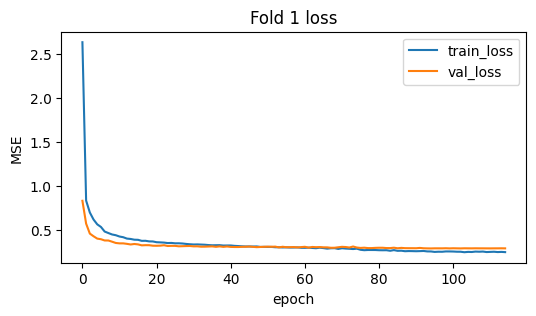


--- Fold 2/5 ---
Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8624 - mse: 3.8624

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 3.8559 - mse: 3.8559 - val_loss: 0.9055 - val_mse: 0.9055 - learning_rate: 0.0010
Epoch 2/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8112 - mse: 0.8112

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8100 - mse: 0.8100 - val_loss: 0.6164 - val_mse: 0.6164 - learning_rate: 0.0010
Epoch 3/200
196/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6726 - mse: 0.6726

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6724 - mse: 0.6724 - val_loss: 0.4997 - val_mse: 0.4997 - learning_rate: 0.0010
Epoch 4/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6039 - mse: 0.6039

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6038 - mse: 0.6038 - val_loss: 0.4547 - val_mse: 0.4547 - learning_rate: 0.0010
Epoch 5/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5257 - mse: 0.5257 - val_loss: 0.4577 - val_mse: 0.4577 - learning_rate: 0.0010
Epoch 6/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5065 - mse: 0.5065

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5066 - mse: 0.5066 - val_loss: 0.4250 - val_mse: 0.4250 - learning_rate: 0.0010
Epoch 7/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4898 - mse: 0.4898

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4895 - mse: 0.4895 - val_loss: 0.4107 - val_mse: 0.4107 - learning_rate: 0.0010
Epoch 8/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4585 - mse: 0.4585

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4589 - mse: 0.4589 - val_loss: 0.4092 - val_mse: 0.4092 - learning_rate: 0.0010
Epoch 9/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4426 - mse: 0.4426

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4429 - mse: 0.4429 - val_loss: 0.3959 - val_mse: 0.3959 - learning_rate: 0.0010
Epoch 10/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4193 - mse: 0.4193 - val_loss: 0.3983 - val_mse: 0.3983 - learning_rate: 0.0010
Epoch 11/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4246 - mse: 0.4246

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4243 - mse: 0.4243 - val_loss: 0.3871 - val_mse: 0.3871 - learning_rate: 0.0010
Epoch 12/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4056 - mse: 0.4056

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4058 - mse: 0.4058 - val_loss: 0.3664 - val_mse: 0.3664 - learning_rate: 0.0010
Epoch 13/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4001 - mse: 0.4001 - val_loss: 0.3726 - val_mse: 0.3726 - learning_rate: 0.0010
Epoch 14/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3907 - mse: 0.3907

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3912 - mse: 0.3912 - val_loss: 0.3642 - val_mse: 0.3642 - learning_rate: 0.0010
Epoch 15/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3851 - mse: 0.3851 - val_loss: 0.3677 - val_mse: 0.3677 - learning_rate: 0.0010
Epoch 16/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3780 - mse: 0.3780

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3787 - mse: 0.3787 - val_loss: 0.3550 - val_mse: 0.3550 - learning_rate: 0.0010
Epoch 17/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3791 - mse: 0.3791 - val_loss: 0.3567 - val_mse: 0.3567 - learning_rate: 0.0010
Epoch 18/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3741 - mse: 0.3741

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3740 - mse: 0.3740 - val_loss: 0.3533 - val_mse: 0.3533 - learning_rate: 0.0010
Epoch 19/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3690 - mse: 0.3690

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3692 - mse: 0.3692 - val_loss: 0.3486 - val_mse: 0.3486 - learning_rate: 0.0010
Epoch 20/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3593 - mse: 0.3593

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3599 - mse: 0.3599 - val_loss: 0.3423 - val_mse: 0.3423 - learning_rate: 0.0010
Epoch 21/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3562 - mse: 0.3562 - val_loss: 0.3494 - val_mse: 0.3494 - learning_rate: 0.0010
Epoch 22/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3547 - mse: 0.3547 - val_loss: 0.3465 - val_mse: 0.3465 - learning_rate: 0.0010
Epoch 23/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3487 - mse: 0.3487

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3491 - mse: 0.3491 - val_loss: 0.3398 - val_mse: 0.3398 - learning_rate: 0.0010
Epoch 24/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3567 - mse: 0.3567 - val_loss: 0.3435 - val_mse: 0.3435 - learning_rate: 0.0010
Epoch 25/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3433 - mse: 0.3433

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3438 - mse: 0.3438 - val_loss: 0.3334 - val_mse: 0.3334 - learning_rate: 0.0010
Epoch 26/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3435 - mse: 0.3435

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3439 - mse: 0.3439 - val_loss: 0.3301 - val_mse: 0.3301 - learning_rate: 0.0010
Epoch 27/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3464 - mse: 0.3464 - val_loss: 0.3309 - val_mse: 0.3309 - learning_rate: 0.0010
Epoch 28/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3380 - mse: 0.3380 - val_loss: 0.3304 - val_mse: 0.3304 - learning_rate: 0.0010
Epoch 29/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3355 - mse: 0.3355 - val_loss: 0.3366 - val_mse: 0.3366 - learning_rate: 0.0010
Epoch 30/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3350 - mse: 0.3350 - val_loss: 0.3363 - val_mse: 0.3363 - learning_rate: 0.0010
Epoch 31/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3357 - mse: 0.3357 - val_loss: 0.3304 - val_mse: 0.3304 - learning_rate: 0.0010
Epoch 32/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3349 - mse: 0.3349

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3350 - mse: 0.3350 - val_loss: 0.3280 - val_mse: 0.3280 - learning_rate: 0.0010
Epoch 33/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3282 - mse: 0.3282 - val_loss: 0.3325 - val_mse: 0.3325 - learning_rate: 0.0010
Epoch 34/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3254 - mse: 0.3254

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3259 - mse: 0.3259 - val_loss: 0.3270 - val_mse: 0.3270 - learning_rate: 0.0010
Epoch 35/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3218 - mse: 0.3218 - val_loss: 0.3318 - val_mse: 0.3318 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3362 - val_mse: 0.3362 - learning_rate: 0.0010
Epoch 37/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3295 - mse: 0.3295 - val_loss: 0.3274 - val_mse: 0.3274 - learning_rate: 0.0010
Epoch 38/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3223 - mse: 0.3223 - val_loss: 0.3286 - val_mse: 0.3286 - learning_rate: 0.0010
Epoch 39/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3207 - mse: 0.3207

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3212 - mse: 0.3212 - val_loss: 0.3235 - val_mse: 0.3235 - learning_rate: 0.0010
Epoch 40/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3153 - mse: 0.3153

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3157 - mse: 0.3157 - val_loss: 0.3230 - val_mse: 0.3230 - learning_rate: 0.0010
Epoch 41/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3181 - mse: 0.3181

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3182 - mse: 0.3182 - val_loss: 0.3176 - val_mse: 0.3176 - learning_rate: 0.0010
Epoch 42/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3188 - mse: 0.3188 - val_loss: 0.3202 - val_mse: 0.3202 - learning_rate: 0.0010
Epoch 43/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3080 - mse: 0.3080

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3087 - mse: 0.3087 - val_loss: 0.3143 - val_mse: 0.3143 - learning_rate: 0.0010
Epoch 44/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3218 - mse: 0.3218 - val_loss: 0.3191 - val_mse: 0.3191 - learning_rate: 0.0010
Epoch 45/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3120 - mse: 0.3120 - val_loss: 0.3201 - val_mse: 0.3201 - learning_rate: 0.0010
Epoch 46/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3153 - mse: 0.3153 - val_loss: 0.3158 - val_mse: 0.3158 - learning_rate: 0.0010
Epoch 47/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3143 - mse: 0.3143 - val_loss: 0.3148 - val_mse: 0.3148 - learning_rate: 0.0010
Epoch 48/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3063 - mse: 0.3063 - val_loss: 0.3178 - val_mse: 0.3178 - learning_rate: 0.0010
Epoch 49/200
199/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3080 - mse: 0.3080

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3082 - mse: 0.3082 - val_loss: 0.3131 - val_mse: 0.3131 - learning_rate: 0.0010
Epoch 50/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3069 - mse: 0.3069 - val_loss: 0.3176 - val_mse: 0.3176 - learning_rate: 0.0010
Epoch 51/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3062 - mse: 0.3062 - val_loss: 0.3182 - val_mse: 0.3182 - learning_rate: 0.0010
Epoch 52/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3096 - mse: 0.3096 - val_loss: 0.3142 - val_mse: 0.3142 - learning_rate: 0.0010
Epoch 53/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3056 - mse: 0.3056 - val_loss: 0.3143 - val_mse: 0.3143 - learning_rate: 0.0010
Epoch 54/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2971 - mse: 0.2971 - val_loss: 0.3174 - val_mse: 0.3174 - learning_rate: 0.0010
Epoch 55/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3037 - mse: 0.3037 - val_loss: 0.3171 - val_mse: 0.3171 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3016 - mse: 0.3016 - val_loss: 0.3116 - val_mse: 0.3116 - learning_rate: 0.0010
Epoch 57/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3004 - mse: 0.3004 - val_loss: 0.3138 - val_mse: 0.3138 - learning_rate: 0.0010
Epoch 58/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3008 - mse: 0.3008

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3010 - mse: 0.3010 - val_loss: 0.3096 - val_mse: 0.3096 - learning_rate: 0.0010
Epoch 59/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3015 - mse: 0.3015 - val_loss: 0.3218 - val_mse: 0.3218 - learning_rate: 0.0010
Epoch 60/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2979 - mse: 0.2979 - val_loss: 0.3117 - val_mse: 0.3117 - learning_rate: 0.0010
Epoch 61/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2925 - mse: 0.2925 - val_loss: 0.3115 - val_mse: 0.3115 - learning_rate: 0.0010
Epoch 62/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2949 - mse: 0.2949

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2952 - mse: 0.2952 - val_loss: 0.3082 - val_mse: 0.3082 - learning_rate: 0.0010
Epoch 63/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2959 - mse: 0.2959 - val_loss: 0.3092 - val_mse: 0.3092 - learning_rate: 0.0010
Epoch 64/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2944 - mse: 0.2944 - val_loss: 0.3104 - val_mse: 0.3104 - learning_rate: 0.0010
Epoch 65/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3016 - mse: 0.3016 - val_loss: 0.3096 - val_mse: 0.3096 - learning_rate: 0.0010
Epoch 66/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2895 - mse: 0.2895 - val_loss: 0.3092 - val_mse: 0.3092 - learning_rate: 0.0010
Epoch 67/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2864 - mse: 0.2864 - val_loss: 0.3085 - val_mse: 0.3085 - learning_rate: 0.0010
Epoch 68/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2916 - mse: 0.2916 - val_loss: 0.3138 - val_mse: 0.3138 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2840 - mse: 0.2840 - val_loss: 0.3051 - val_mse: 0.3051 - learning_rate: 5.0000e-04
Epoch 71/200
201/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2722 - mse: 0.2722

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2724 - mse: 0.2724 - val_loss: 0.3039 - val_mse: 0.3039 - learning_rate: 5.0000e-04
Epoch 72/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2744 - mse: 0.2744

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2750 - mse: 0.2750 - val_loss: 0.3000 - val_mse: 0.3000 - learning_rate: 5.0000e-04
Epoch 73/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2721 - mse: 0.2721 - val_loss: 0.3052 - val_mse: 0.3052 - learning_rate: 5.0000e-04
Epoch 74/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2792 - mse: 0.2792 - val_loss: 0.3037 - val_mse: 0.3037 - learning_rate: 5.0000e-04
Epoch 75/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2724 - mse: 0.2724 - val_loss: 0.3040 - val_mse: 0.3040 - learning_rate: 5.0000e-04
Epoch 76/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2738 - mse: 0.2738 - val_loss: 0.3052 - val_mse: 0.3052 - learning_rate: 5.0000e-04
Epoch 77/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2745 - mse: 0.2745 - val_loss: 0.3003 - val_mse: 0.3003 - learning_rate: 5.0000e-04
Epoch 78/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2687 - mse: 0.2687 - val_loss: 0.3027 - val_mse: 0.3027 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2640 - mse: 0.2640 - val_loss: 0.2988 - val_mse: 0.2988 - learning_rate: 2.5000e-04
Epoch 82/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2638 - mse: 0.2638 - val_loss: 0.3004 - val_mse: 0.3004 - learning_rate: 2.5000e-04
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2636 - mse: 0.2636 - val_loss: 0.3005 - val_mse: 0.3005 - learning_rate: 2.5000e-04
Epoch 84/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2618 - mse: 0.2618 - val_loss: 0.3027 - val_mse: 0.3027 - learning_rate: 2.5000e-04
Epoch 85/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2597 - mse: 0.2597 - val_loss: 0.3021 - val_mse: 0.3021 - learning_rate: 2.5000e-04
Epoch 86/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2678 - mse: 0.2678 - val_loss: 0.3005 - val_mse: 0.3005 - learning_rate: 2.5000e-04
Epoch 87/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2618 - mse: 0.2618 - val_loss: 0.3039 - val_mse: 0.3039 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2631 - mse: 0.2631 - val_loss: 0.2987 - val_mse: 0.2987 - learning_rate: 1.2500e-04
Epoch 92/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2617 - mse: 0.2617 - val_loss: 0.2998 - val_mse: 0.2998 - learning_rate: 1.2500e-04
Epoch 93/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2555 - mse: 0.2555

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2557 - mse: 0.2557 - val_loss: 0.2986 - val_mse: 0.2986 - learning_rate: 1.2500e-04
Epoch 94/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2570 - mse: 0.2570

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2572 - mse: 0.2572 - val_loss: 0.2982 - val_mse: 0.2982 - learning_rate: 1.2500e-04
Epoch 95/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2603 - mse: 0.2603 - val_loss: 0.2987 - val_mse: 0.2987 - learning_rate: 1.2500e-04
Epoch 96/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2551 - mse: 0.2551 - val_loss: 0.2982 - val_mse: 0.2982 - learning_rate: 1.2500e-04
Epoch 97/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2592 - mse: 0.2592 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 1.2500e-04
Epoch 98/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2557 - mse: 0.2557 - val_loss: 0.2993 - val_mse: 0.2993 - learning_rate: 1.2500e-04
Epoch 99/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2610 - mse: 0.2610 - val_loss: 0.2996 - val_mse: 0.2996 - learning_rate: 1.2500e-04
Epoch 100/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2570 - mse: 0.2570 - val_loss: 0.2984 - val_mse: 0.2984 - le

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2593 - mse: 0.2593 - val_loss: 0.2980 - val_mse: 0.2980 - learning_rate: 1.2500e-04
Epoch 102/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2571 - mse: 0.2571 - val_loss: 0.2987 - val_mse: 0.2987 - learning_rate: 1.2500e-04
Epoch 103/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2534 - mse: 0.2534 - val_loss: 0.2987 - val_mse: 0.2987 - learning_rate: 1.2500e-04
Epoch 104/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2560 - mse: 0.2560 - val_loss: 0.2997 - val_mse: 0.2997 - learning_rate: 1.2500e-04
Epoch 105/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2549 - mse: 0.2549 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 1.2500e-04
Epoch 106/200
196/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2561 - mse: 0.2561

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2564 - mse: 0.2564 - val_loss: 0.2977 - val_mse: 0.2977 - learning_rate: 1.2500e-04
Epoch 107/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2545 - mse: 0.2545

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2548 - mse: 0.2548 - val_loss: 0.2969 - val_mse: 0.2969 - learning_rate: 1.2500e-04
Epoch 108/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2559 - mse: 0.2559 - val_loss: 0.2983 - val_mse: 0.2983 - learning_rate: 1.2500e-04
Epoch 109/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2549 - mse: 0.2549 - val_loss: 0.3002 - val_mse: 0.3002 - learning_rate: 1.2500e-04
Epoch 110/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2582 - mse: 0.2582 - val_loss: 0.2974 - val_mse: 0.2974 - learning_rate: 1.2500e-04
Epoch 111/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2587 - mse: 0.2587 - val_loss: 0.2974 - val_mse: 0.2974 - learning_rate: 1.2500e-04
Epoch 112/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2583 - mse: 0.2583 - val_loss: 0.2979 - val_mse: 0.2979 - learning_rate: 1.2500e-04
Epoch 113/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2542 - mse: 0.2542 - val_loss: 0.2985 - val_mse: 0.2985

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2520 - mse: 0.2520 - val_loss: 0.2964 - val_mse: 0.2964 - learning_rate: 6.2500e-05
Epoch 116/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2533 - mse: 0.2533 - val_loss: 0.2970 - val_mse: 0.2970 - learning_rate: 6.2500e-05
Epoch 117/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2541 - mse: 0.2541 - val_loss: 0.2970 - val_mse: 0.2970 - learning_rate: 6.2500e-05
Epoch 118/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2523 - mse: 0.2523 - val_loss: 0.2970 - val_mse: 0.2970 - learning_rate: 6.2500e-05
Epoch 119/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2515 - mse: 0.2515 - val_loss: 0.2967 - val_mse: 0.2967 - learning_rate: 6.2500e-05
Epoch 120/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2541 - mse: 0.2541 - val_loss: 0.2970 - val_mse: 0.2970 - learning_rate: 6.2500e-05
Epoch 121/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2553 - mse: 0.2553 - val_loss: 0.2968 - val_mse: 0.2968

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2481 - mse: 0.2481 - val_loss: 0.2959 - val_mse: 0.2959 - learning_rate: 3.1250e-05
Epoch 130/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2570 - mse: 0.2570 - val_loss: 0.2962 - val_mse: 0.2962 - learning_rate: 3.1250e-05
Epoch 131/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2505 - mse: 0.2505 - val_loss: 0.2964 - val_mse: 0.2964 - learning_rate: 3.1250e-05
Epoch 132/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2468 - mse: 0.2468 - val_loss: 0.2966 - val_mse: 0.2966 - learning_rate: 3.1250e-05
Epoch 133/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2547 - mse: 0.2547 - val_loss: 0.2961 - val_mse: 0.2961 - learning_rate: 3.1250e-05
Epoch 134/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2515 - mse: 0.2515

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2517 - mse: 0.2517 - val_loss: 0.2957 - val_mse: 0.2957 - learning_rate: 3.1250e-05
Epoch 135/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2542 - mse: 0.2542 - val_loss: 0.2957 - val_mse: 0.2957 - learning_rate: 3.1250e-05
Epoch 136/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2474 - mse: 0.2474

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2474 - mse: 0.2474 - val_loss: 0.2953 - val_mse: 0.2953 - learning_rate: 3.1250e-05
Epoch 137/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2515 - mse: 0.2515

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2515 - mse: 0.2515 - val_loss: 0.2952 - val_mse: 0.2952 - learning_rate: 3.1250e-05
Epoch 138/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2516 - mse: 0.2516 - val_loss: 0.2955 - val_mse: 0.2955 - learning_rate: 3.1250e-05
Epoch 139/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2539 - mse: 0.2539 - val_loss: 0.2955 - val_mse: 0.2955 - learning_rate: 3.1250e-05
Epoch 140/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2479 - mse: 0.2479 - val_loss: 0.2955 - val_mse: 0.2955 - learning_rate: 3.1250e-05
Epoch 141/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2479 - mse: 0.2479 - val_loss: 0.2957 - val_mse: 0.2957 - learning_rate: 3.1250e-05
Epoch 142/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2522 - mse: 0.2522 - val_loss: 0.2956 - val_mse: 0.2956 - learning_rate: 3.1250e-05
Epoch 143/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2496 - mse: 0.2496 - val_loss: 0.2960 - val_mse: 0.2960

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2525 - mse: 0.2525 - val_loss: 0.2951 - val_mse: 0.2951 - learning_rate: 1.5625e-05
Epoch 151/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2459 - mse: 0.2459
Epoch 151: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2464 - mse: 0.2464 - val_loss: 0.2955 - val_mse: 0.2955 - learning_rate: 1.5625e-05
Epoch 152/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2485 - mse: 0.2485 - val_loss: 0.2954 - val_mse: 0.2954 - learning_rate: 7.8125e-06
Epoch 153/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2463 - mse: 0.2463 - val_loss: 0.2953 - val_mse: 0.2953 - learning_rate: 7.8125e-06
Epoch 154/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2480 - mse: 0.2480 - val_loss: 0.2952 - val_mse: 0.2952 - learning_rate: 7.8125e-06
Epoch 155/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2492 - mse: 0.2492 - val_loss: 0.2953 - val_mse: 0.2953 

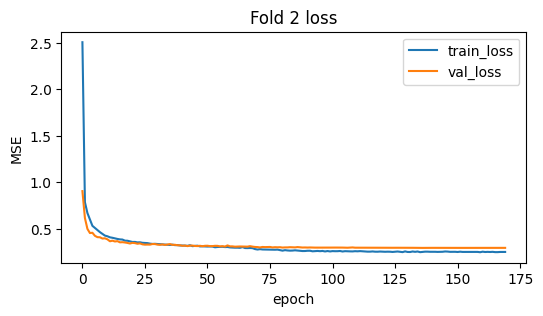


--- Fold 3/5 ---
Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0890 - mse: 4.0890

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 4.0817 - mse: 4.0817 - val_loss: 0.8504 - val_mse: 0.8504 - learning_rate: 0.0010
Epoch 2/200
196/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9107 - mse: 0.9107

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9067 - mse: 0.9067 - val_loss: 0.5218 - val_mse: 0.5218 - learning_rate: 0.0010
Epoch 3/200
200/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6954 - mse: 0.6954

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6950 - mse: 0.6950 - val_loss: 0.4529 - val_mse: 0.4529 - learning_rate: 0.0010
Epoch 4/200
186/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6179 - mse: 0.6179

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6161 - mse: 0.6161 - val_loss: 0.4127 - val_mse: 0.4127 - learning_rate: 0.0010
Epoch 5/200
199/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5719 - mse: 0.5719

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5714 - mse: 0.5714 - val_loss: 0.3834 - val_mse: 0.3834 - learning_rate: 0.0010
Epoch 6/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5220 - mse: 0.5220 - val_loss: 0.4058 - val_mse: 0.4058 - learning_rate: 0.0010
Epoch 7/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4952 - mse: 0.4952

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4951 - mse: 0.4951 - val_loss: 0.3672 - val_mse: 0.3672 - learning_rate: 0.0010
Epoch 8/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4734 - mse: 0.4734 - val_loss: 0.3681 - val_mse: 0.3681 - learning_rate: 0.0010
Epoch 9/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4589 - mse: 0.4589

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4589 - mse: 0.4589 - val_loss: 0.3615 - val_mse: 0.3615 - learning_rate: 0.0010
Epoch 10/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4326 - mse: 0.4326 - val_loss: 0.3730 - val_mse: 0.3730 - learning_rate: 0.0010
Epoch 11/200
199/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4236 - mse: 0.4236

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4238 - mse: 0.4238 - val_loss: 0.3564 - val_mse: 0.3564 - learning_rate: 0.0010
Epoch 12/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4117 - mse: 0.4117

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4118 - mse: 0.4118 - val_loss: 0.3373 - val_mse: 0.3373 - learning_rate: 0.0010
Epoch 13/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4091 - mse: 0.4091 - val_loss: 0.3397 - val_mse: 0.3397 - learning_rate: 0.0010
Epoch 14/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4038 - mse: 0.4038

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4039 - mse: 0.4039 - val_loss: 0.3302 - val_mse: 0.3302 - learning_rate: 0.0010
Epoch 15/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3934 - mse: 0.3934 - val_loss: 0.3406 - val_mse: 0.3406 - learning_rate: 0.0010
Epoch 16/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3911 - mse: 0.3911

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3913 - mse: 0.3913 - val_loss: 0.3228 - val_mse: 0.3228 - learning_rate: 0.0010
Epoch 17/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3785 - mse: 0.3785 - val_loss: 0.3248 - val_mse: 0.3248 - learning_rate: 0.0010
Epoch 18/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3719 - mse: 0.3719

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3722 - mse: 0.3722 - val_loss: 0.3205 - val_mse: 0.3205 - learning_rate: 0.0010
Epoch 19/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3682 - mse: 0.3682

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3684 - mse: 0.3684 - val_loss: 0.3153 - val_mse: 0.3153 - learning_rate: 0.0010
Epoch 20/200
205/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3614 - mse: 0.3614

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3614 - mse: 0.3614 - val_loss: 0.3087 - val_mse: 0.3087 - learning_rate: 0.0010
Epoch 21/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3574 - mse: 0.3574

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3576 - mse: 0.3576 - val_loss: 0.3050 - val_mse: 0.3050 - learning_rate: 0.0010
Epoch 22/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3533 - mse: 0.3533 - val_loss: 0.3121 - val_mse: 0.3121 - learning_rate: 0.0010
Epoch 23/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3536 - mse: 0.3536 - val_loss: 0.3069 - val_mse: 0.3069 - learning_rate: 0.0010
Epoch 24/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3516 - mse: 0.3516 - val_loss: 0.3052 - val_mse: 0.3052 - learning_rate: 0.0010
Epoch 25/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3552 - mse: 0.3552 - val_loss: 0.3089 - val_mse: 0.3089 - learning_rate: 0.0010
Epoch 26/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3433 - mse: 0.3433

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3435 - mse: 0.3435 - val_loss: 0.3006 - val_mse: 0.3006 - learning_rate: 0.0010
Epoch 27/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3389 - mse: 0.3389

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3387 - mse: 0.3387 - val_loss: 0.2999 - val_mse: 0.2999 - learning_rate: 0.0010
Epoch 28/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3409 - mse: 0.3409 - val_loss: 0.3010 - val_mse: 0.3010 - learning_rate: 0.0010
Epoch 29/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3357 - mse: 0.3357

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3361 - mse: 0.3361 - val_loss: 0.2987 - val_mse: 0.2987 - learning_rate: 0.0010
Epoch 30/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3449 - mse: 0.3449 - val_loss: 0.3035 - val_mse: 0.3035 - learning_rate: 0.0010
Epoch 31/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3339 - mse: 0.3339

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3340 - mse: 0.3340 - val_loss: 0.2922 - val_mse: 0.2922 - learning_rate: 0.0010
Epoch 32/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3308 - mse: 0.3308

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3310 - mse: 0.3310 - val_loss: 0.2894 - val_mse: 0.2894 - learning_rate: 0.0010
Epoch 33/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3294 - mse: 0.3294 - val_loss: 0.2943 - val_mse: 0.2943 - learning_rate: 0.0010
Epoch 34/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3313 - mse: 0.3313 - val_loss: 0.2934 - val_mse: 0.2934 - learning_rate: 0.0010
Epoch 35/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3275 - mse: 0.3275

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3276 - mse: 0.3276 - val_loss: 0.2850 - val_mse: 0.2850 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3269 - mse: 0.3269 - val_loss: 0.2851 - val_mse: 0.2851 - learning_rate: 0.0010
Epoch 37/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3212 - mse: 0.3212 - val_loss: 0.2921 - val_mse: 0.2921 - learning_rate: 0.0010
Epoch 38/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3239 - mse: 0.3239 - val_loss: 0.2894 - val_mse: 0.2894 - learning_rate: 0.0010
Epoch 39/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3230 - mse: 0.3230 - val_loss: 0.2857 - val_mse: 0.2857 - learning_rate: 0.0010
Epoch 40/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3153 - mse: 0.3153 - val_loss: 0.2859 - val_mse: 0.2859 - learning_rate: 0.0010
Epoch 41/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3176 - mse: 0.3176 - val_loss: 0.2898 - val_mse: 0.2898 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3152 - mse: 0.3152 - val_loss: 0.2813 - val_mse: 0.2813 - learning_rate: 0.0010
Epoch 43/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3134 - mse: 0.3134 - val_loss: 0.2839 - val_mse: 0.2839 - learning_rate: 0.0010
Epoch 44/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3134 - mse: 0.3134 - val_loss: 0.2882 - val_mse: 0.2882 - learning_rate: 0.0010
Epoch 45/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3132 - mse: 0.3132

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3132 - mse: 0.3132 - val_loss: 0.2806 - val_mse: 0.2806 - learning_rate: 0.0010
Epoch 46/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3071 - mse: 0.3071

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3074 - mse: 0.3074 - val_loss: 0.2799 - val_mse: 0.2799 - learning_rate: 0.0010
Epoch 47/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3081 - mse: 0.3081 - val_loss: 0.2841 - val_mse: 0.2841 - learning_rate: 0.0010
Epoch 48/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3098 - mse: 0.3098 - val_loss: 0.2806 - val_mse: 0.2806 - learning_rate: 0.0010
Epoch 49/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3045 - mse: 0.3045 - val_loss: 0.2849 - val_mse: 0.2849 - learning_rate: 0.0010
Epoch 50/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3054 - mse: 0.3054 - val_loss: 0.2900 - val_mse: 0.2900 - learning_rate: 0.0010
Epoch 51/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3053 - mse: 0.3053 - val_loss: 0.2804 - val_mse: 0.2804 - learning_rate: 0.0010
Epoch 52/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3030 - mse: 0.3030 - val_loss: 0.2914 - val_mse: 0.2914 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2907 - mse: 0.2907 - val_loss: 0.2736 - val_mse: 0.2736 - learning_rate: 5.0000e-04
Epoch 55/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2959 - mse: 0.2959 - val_loss: 0.2742 - val_mse: 0.2742 - learning_rate: 5.0000e-04
Epoch 56/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2924 - mse: 0.2924

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2922 - mse: 0.2922 - val_loss: 0.2731 - val_mse: 0.2731 - learning_rate: 5.0000e-04
Epoch 57/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2862 - mse: 0.2862 - val_loss: 0.2787 - val_mse: 0.2787 - learning_rate: 5.0000e-04
Epoch 58/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2915 - mse: 0.2915 - val_loss: 0.2796 - val_mse: 0.2796 - learning_rate: 5.0000e-04
Epoch 59/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2886 - mse: 0.2886 - val_loss: 0.2756 - val_mse: 0.2756 - learning_rate: 5.0000e-04
Epoch 60/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2843 - mse: 0.2843

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2840 - mse: 0.2840 - val_loss: 0.2719 - val_mse: 0.2719 - learning_rate: 5.0000e-04
Epoch 61/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2837 - mse: 0.2837 - val_loss: 0.2760 - val_mse: 0.2760 - learning_rate: 5.0000e-04
Epoch 62/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2872 - mse: 0.2872 - val_loss: 0.2824 - val_mse: 0.2824 - learning_rate: 5.0000e-04
Epoch 63/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2859 - mse: 0.2859 - val_loss: 0.2786 - val_mse: 0.2786 - learning_rate: 5.0000e-04
Epoch 64/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2868 - mse: 0.2868 - val_loss: 0.2781 - val_mse: 0.2781 - learning_rate: 5.0000e-04
Epoch 65/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2870 - mse: 0.2870 - val_loss: 0.2810 - val_mse: 0.2810 - learning_rate: 5.0000e-04
Epoch 66/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2869 - mse: 0.2869 - val_loss: 0.2765 - val_mse: 0.2765 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2707 - mse: 0.2707 - val_loss: 0.2707 - val_mse: 0.2707 - learning_rate: 1.2500e-04
Epoch 76/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2717 - mse: 0.2717

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2714 - mse: 0.2714 - val_loss: 0.2698 - val_mse: 0.2698 - learning_rate: 1.2500e-04
Epoch 77/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2706 - mse: 0.2706

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2704 - mse: 0.2704 - val_loss: 0.2694 - val_mse: 0.2694 - learning_rate: 1.2500e-04
Epoch 78/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2685 - mse: 0.2685 - val_loss: 0.2708 - val_mse: 0.2708 - learning_rate: 1.2500e-04
Epoch 79/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2746 - mse: 0.2746 - val_loss: 0.2701 - val_mse: 0.2701 - learning_rate: 1.2500e-04
Epoch 80/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2693 - mse: 0.2693

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2693 - mse: 0.2693 - val_loss: 0.2693 - val_mse: 0.2693 - learning_rate: 1.2500e-04
Epoch 81/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2710 - mse: 0.2710 - val_loss: 0.2701 - val_mse: 0.2701 - learning_rate: 1.2500e-04
Epoch 82/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2664 - mse: 0.2664 - val_loss: 0.2713 - val_mse: 0.2713 - learning_rate: 1.2500e-04
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2697 - mse: 0.2697 - val_loss: 0.2715 - val_mse: 0.2715 - learning_rate: 1.2500e-04
Epoch 84/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2667 - mse: 0.2667 - val_loss: 0.2705 - val_mse: 0.2705 - learning_rate: 1.2500e-04
Epoch 85/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2665 - mse: 0.2665 - val_loss: 0.2698 - val_mse: 0.2698 - learning_rate: 1.2500e-04
Epoch 86/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2683 - mse: 0.2683 - val_loss: 0.2713 - val_mse: 0.2713 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2654 - mse: 0.2654 - val_loss: 0.2683 - val_mse: 0.2683 - learning_rate: 6.2500e-05
Epoch 89/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2645 - mse: 0.2645

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2644 - mse: 0.2644 - val_loss: 0.2682 - val_mse: 0.2682 - learning_rate: 6.2500e-05
Epoch 90/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2645 - mse: 0.2645 - val_loss: 0.2685 - val_mse: 0.2685 - learning_rate: 6.2500e-05
Epoch 91/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2654 - mse: 0.2654 - val_loss: 0.2682 - val_mse: 0.2682 - learning_rate: 6.2500e-05
Epoch 92/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2630 - mse: 0.2630 - val_loss: 0.2683 - val_mse: 0.2683 - learning_rate: 6.2500e-05
Epoch 93/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2670 - mse: 0.2670

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2664 - mse: 0.2664 - val_loss: 0.2679 - val_mse: 0.2679 - learning_rate: 6.2500e-05
Epoch 94/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2625 - mse: 0.2625 - val_loss: 0.2688 - val_mse: 0.2688 - learning_rate: 6.2500e-05
Epoch 95/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2686 - mse: 0.2686 - val_loss: 0.2682 - val_mse: 0.2682 - learning_rate: 6.2500e-05
Epoch 96/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2629 - mse: 0.2629 - val_loss: 0.2679 - val_mse: 0.2679 - learning_rate: 6.2500e-05
Epoch 97/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2646 - mse: 0.2646

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2643 - mse: 0.2643 - val_loss: 0.2679 - val_mse: 0.2679 - learning_rate: 6.2500e-05
Epoch 98/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2652 - mse: 0.2652 - val_loss: 0.2690 - val_mse: 0.2690 - learning_rate: 6.2500e-05
Epoch 99/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2651 - mse: 0.2651

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2650 - mse: 0.2650 - val_loss: 0.2678 - val_mse: 0.2678 - learning_rate: 6.2500e-05
Epoch 100/200
184/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619 - mse: 0.2619
Epoch 100: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2615 - mse: 0.2615 - val_loss: 0.2685 - val_mse: 0.2685 - learning_rate: 6.2500e-05
Epoch 101/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2648 - mse: 0.2648

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2645 - mse: 0.2645 - val_loss: 0.2677 - val_mse: 0.2677 - learning_rate: 3.1250e-05
Epoch 102/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2630 - mse: 0.2630 - val_loss: 0.2677 - val_mse: 0.2677 - learning_rate: 3.1250e-05
Epoch 103/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2654 - mse: 0.2654

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2652 - mse: 0.2652 - val_loss: 0.2676 - val_mse: 0.2676 - learning_rate: 3.1250e-05
Epoch 104/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2612 - mse: 0.2612

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2610 - mse: 0.2610 - val_loss: 0.2674 - val_mse: 0.2674 - learning_rate: 3.1250e-05
Epoch 105/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2621 - mse: 0.2621

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2620 - mse: 0.2620 - val_loss: 0.2674 - val_mse: 0.2674 - learning_rate: 3.1250e-05
Epoch 106/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2674 - mse: 0.2674 - val_loss: 0.2675 - val_mse: 0.2675 - learning_rate: 3.1250e-05
Epoch 107/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2609 - mse: 0.2609 - val_loss: 0.2675 - val_mse: 0.2675 - learning_rate: 3.1250e-05
Epoch 108/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2604 - mse: 0.2604 - val_loss: 0.2676 - val_mse: 0.2676 - learning_rate: 3.1250e-05
Epoch 109/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2595 - mse: 0.2595

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2593 - mse: 0.2593 - val_loss: 0.2673 - val_mse: 0.2673 - learning_rate: 3.1250e-05
Epoch 110/200
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2609 - mse: 0.2609

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2609 - mse: 0.2609 - val_loss: 0.2672 - val_mse: 0.2672 - learning_rate: 3.1250e-05
Epoch 111/200
185/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2633 - mse: 0.2633

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2628 - mse: 0.2628 - val_loss: 0.2672 - val_mse: 0.2672 - learning_rate: 3.1250e-05
Epoch 112/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2590 - mse: 0.2590

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2590 - mse: 0.2590 - val_loss: 0.2670 - val_mse: 0.2670 - learning_rate: 3.1250e-05
Epoch 113/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2669 - mse: 0.2669 - val_loss: 0.2672 - val_mse: 0.2672 - learning_rate: 3.1250e-05
Epoch 114/200
203/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2665 - mse: 0.2665

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2665 - mse: 0.2665 - val_loss: 0.2668 - val_mse: 0.2668 - learning_rate: 3.1250e-05
Epoch 115/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2600 - mse: 0.2600 - val_loss: 0.2669 - val_mse: 0.2669 - learning_rate: 3.1250e-05
Epoch 116/200
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2590 - mse: 0.2590

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2590 - mse: 0.2590 - val_loss: 0.2667 - val_mse: 0.2667 - learning_rate: 3.1250e-05
Epoch 117/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2552 - mse: 0.2552 - val_loss: 0.2673 - val_mse: 0.2673 - learning_rate: 3.1250e-05
Epoch 118/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2609 - mse: 0.2609 - val_loss: 0.2673 - val_mse: 0.2673 - learning_rate: 3.1250e-05
Epoch 119/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2681 - mse: 0.2681 - val_loss: 0.2674 - val_mse: 0.2674 - learning_rate: 3.1250e-05
Epoch 120/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2637 - mse: 0.2637 - val_loss: 0.2669 - val_mse: 0.2669 - learning_rate: 3.1250e-05
Epoch 121/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2579 - mse: 0.2579 - val_loss: 0.2676 - val_mse: 0.2676 - learning_rate: 3.1250e-05
Epoch 122/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2633 - mse: 0.2633 - val_loss: 0.2672 - val_mse: 0.2672

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2571 - mse: 0.2571 - val_loss: 0.2666 - val_mse: 0.2666 - learning_rate: 7.8125e-06
Epoch 136/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2605 - mse: 0.2605

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2601 - mse: 0.2601 - val_loss: 0.2664 - val_mse: 0.2664 - learning_rate: 7.8125e-06
Epoch 137/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2635 - mse: 0.2635 - val_loss: 0.2666 - val_mse: 0.2666 - learning_rate: 7.8125e-06
Epoch 138/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2576 - mse: 0.2576 - val_loss: 0.2666 - val_mse: 0.2666 - learning_rate: 7.8125e-06
Epoch 139/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2626 - mse: 0.2626 - val_loss: 0.2665 - val_mse: 0.2665 - learning_rate: 7.8125e-06
Epoch 140/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2596 - mse: 0.2596 - val_loss: 0.2667 - val_mse: 0.2667 - learning_rate: 7.8125e-06
Epoch 141/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2593 - mse: 0.2593 - val_loss: 0.2666 - val_mse: 0.2666 - learning_rate: 7.8125e-06
Epoch 142/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2586 - mse: 0.2586 - val_loss: 0.2669 - val_mse: 0.2669

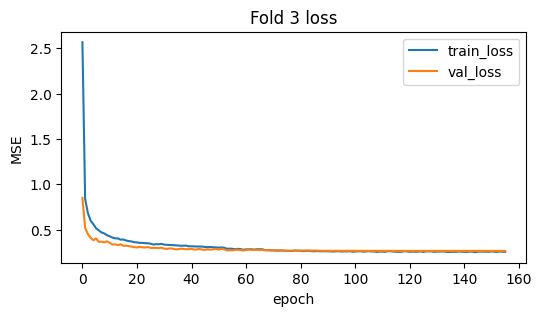


--- Fold 4/5 ---
Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0716 - mse: 4.0716

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.0643 - mse: 4.0643 - val_loss: 0.8713 - val_mse: 0.8713 - learning_rate: 0.0010
Epoch 2/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9002 - mse: 0.9002

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8966 - mse: 0.8966 - val_loss: 0.6341 - val_mse: 0.6341 - learning_rate: 0.0010
Epoch 3/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7694 - mse: 0.7694

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7685 - mse: 0.7685 - val_loss: 0.4884 - val_mse: 0.4884 - learning_rate: 0.0010
Epoch 4/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6547 - mse: 0.6547

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6542 - mse: 0.6542 - val_loss: 0.4393 - val_mse: 0.4393 - learning_rate: 0.0010
Epoch 5/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5747 - mse: 0.5747

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5750 - mse: 0.5750 - val_loss: 0.4318 - val_mse: 0.4318 - learning_rate: 0.0010
Epoch 6/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5356 - mse: 0.5356

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5361 - mse: 0.5361 - val_loss: 0.4252 - val_mse: 0.4252 - learning_rate: 0.0010
Epoch 7/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4961 - mse: 0.4961

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4968 - mse: 0.4968 - val_loss: 0.4048 - val_mse: 0.4048 - learning_rate: 0.0010
Epoch 8/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4783 - mse: 0.4783

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4790 - mse: 0.4790 - val_loss: 0.4010 - val_mse: 0.4010 - learning_rate: 0.0010
Epoch 9/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4717 - mse: 0.4717

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4720 - mse: 0.4720 - val_loss: 0.3823 - val_mse: 0.3823 - learning_rate: 0.0010
Epoch 10/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4493 - mse: 0.4493

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4492 - mse: 0.4492 - val_loss: 0.3777 - val_mse: 0.3777 - learning_rate: 0.0010
Epoch 11/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4301 - mse: 0.4301 - val_loss: 0.3795 - val_mse: 0.3795 - learning_rate: 0.0010
Epoch 12/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4206 - mse: 0.4206

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4213 - mse: 0.4213 - val_loss: 0.3660 - val_mse: 0.3660 - learning_rate: 0.0010
Epoch 13/200
199/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4109 - mse: 0.4109

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4111 - mse: 0.4111 - val_loss: 0.3579 - val_mse: 0.3579 - learning_rate: 0.0010
Epoch 14/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4032 - mse: 0.4032 - val_loss: 0.3640 - val_mse: 0.3640 - learning_rate: 0.0010
Epoch 15/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3940 - mse: 0.3940 - val_loss: 0.3615 - val_mse: 0.3615 - learning_rate: 0.0010
Epoch 16/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3902 - mse: 0.3902 - val_loss: 0.3600 - val_mse: 0.3600 - learning_rate: 0.0010
Epoch 17/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3854 - mse: 0.3854

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3859 - mse: 0.3859 - val_loss: 0.3517 - val_mse: 0.3517 - learning_rate: 0.0010
Epoch 18/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3685 - mse: 0.3685

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3692 - mse: 0.3692 - val_loss: 0.3505 - val_mse: 0.3505 - learning_rate: 0.0010
Epoch 19/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3754 - mse: 0.3754 - val_loss: 0.3622 - val_mse: 0.3622 - learning_rate: 0.0010
Epoch 20/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3677 - mse: 0.3677

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3679 - mse: 0.3679 - val_loss: 0.3405 - val_mse: 0.3405 - learning_rate: 0.0010
Epoch 21/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3649 - mse: 0.3649

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3652 - mse: 0.3652 - val_loss: 0.3380 - val_mse: 0.3380 - learning_rate: 0.0010
Epoch 22/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3635 - mse: 0.3635 - val_loss: 0.3380 - val_mse: 0.3380 - learning_rate: 0.0010
Epoch 23/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3595 - mse: 0.3595

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3599 - mse: 0.3599 - val_loss: 0.3355 - val_mse: 0.3355 - learning_rate: 0.0010
Epoch 24/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3536 - mse: 0.3536 - val_loss: 0.3374 - val_mse: 0.3374 - learning_rate: 0.0010
Epoch 25/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3443 - mse: 0.3443 - val_loss: 0.3410 - val_mse: 0.3410 - learning_rate: 0.0010
Epoch 26/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3504 - mse: 0.3504 - val_loss: 0.3394 - val_mse: 0.3394 - learning_rate: 0.0010
Epoch 27/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3419 - mse: 0.3419 - val_loss: 0.3421 - val_mse: 0.3421 - learning_rate: 0.0010
Epoch 28/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3408 - mse: 0.3408

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3412 - mse: 0.3412 - val_loss: 0.3294 - val_mse: 0.3294 - learning_rate: 0.0010
Epoch 29/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3378 - mse: 0.3378 - val_loss: 0.3381 - val_mse: 0.3381 - learning_rate: 0.0010
Epoch 30/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3384 - mse: 0.3384 - val_loss: 0.3322 - val_mse: 0.3322 - learning_rate: 0.0010
Epoch 31/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3377 - mse: 0.3377

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3380 - mse: 0.3380 - val_loss: 0.3276 - val_mse: 0.3276 - learning_rate: 0.0010
Epoch 32/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3302 - mse: 0.3302

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3309 - mse: 0.3309 - val_loss: 0.3215 - val_mse: 0.3215 - learning_rate: 0.0010
Epoch 33/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3360 - mse: 0.3360 - val_loss: 0.3254 - val_mse: 0.3254 - learning_rate: 0.0010
Epoch 34/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3249 - mse: 0.3249 - val_loss: 0.3252 - val_mse: 0.3252 - learning_rate: 0.0010
Epoch 35/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3279 - mse: 0.3279 - val_loss: 0.3313 - val_mse: 0.3313 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3299 - mse: 0.3299 - val_loss: 0.3254 - val_mse: 0.3254 - learning_rate: 0.0010
Epoch 37/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3269 - mse: 0.3269 - val_loss: 0.3310 - val_mse: 0.3310 - learning_rate: 0.0010
Epoch 38/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3208 - mse: 0.3208 - val_loss: 0.3234 - val_mse: 0.3234 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3137 - mse: 0.3137 - val_loss: 0.3095 - val_mse: 0.3095 - learning_rate: 5.0000e-04
Epoch 41/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3105 - mse: 0.3105

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3110 - mse: 0.3110 - val_loss: 0.3091 - val_mse: 0.3091 - learning_rate: 5.0000e-04
Epoch 42/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3077 - mse: 0.3077

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3081 - mse: 0.3081 - val_loss: 0.3065 - val_mse: 0.3065 - learning_rate: 5.0000e-04
Epoch 43/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3068 - mse: 0.3068 - val_loss: 0.3127 - val_mse: 0.3127 - learning_rate: 5.0000e-04
Epoch 44/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3050 - mse: 0.3050 - val_loss: 0.3090 - val_mse: 0.3090 - learning_rate: 5.0000e-04
Epoch 45/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3011 - mse: 0.3011 - val_loss: 0.3110 - val_mse: 0.3110 - learning_rate: 5.0000e-04
Epoch 46/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3059 - mse: 0.3059 - val_loss: 0.3147 - val_mse: 0.3147 - learning_rate: 5.0000e-04
Epoch 47/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3062 - mse: 0.3062 - val_loss: 0.3116 - val_mse: 0.3116 - learning_rate: 5.0000e-04
Epoch 48/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3039 - mse: 0.3039 - val_loss: 0.3133 - val_mse: 0.3133 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2977 - mse: 0.2977 - val_loss: 0.3030 - val_mse: 0.3030 - learning_rate: 2.5000e-04
Epoch 51/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2954 - mse: 0.2954 - val_loss: 0.3045 - val_mse: 0.3045 - learning_rate: 2.5000e-04
Epoch 52/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2952 - mse: 0.2952

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2956 - mse: 0.2956 - val_loss: 0.3022 - val_mse: 0.3022 - learning_rate: 2.5000e-04
Epoch 53/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2876 - mse: 0.2876 - val_loss: 0.3038 - val_mse: 0.3038 - learning_rate: 2.5000e-04
Epoch 54/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2948 - mse: 0.2948 - val_loss: 0.3045 - val_mse: 0.3045 - learning_rate: 2.5000e-04
Epoch 55/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2894 - mse: 0.2894 - val_loss: 0.3032 - val_mse: 0.3032 - learning_rate: 2.5000e-04
Epoch 56/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2964 - mse: 0.2964 - val_loss: 0.3042 - val_mse: 0.3042 - learning_rate: 2.5000e-04
Epoch 57/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2891 - mse: 0.2891

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2896 - mse: 0.2896 - val_loss: 0.3008 - val_mse: 0.3008 - learning_rate: 2.5000e-04
Epoch 58/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2890 - mse: 0.2890 - val_loss: 0.3029 - val_mse: 0.3029 - learning_rate: 2.5000e-04
Epoch 59/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2939 - mse: 0.2939 - val_loss: 0.3036 - val_mse: 0.3036 - learning_rate: 2.5000e-04
Epoch 60/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2891 - mse: 0.2891 - val_loss: 0.3034 - val_mse: 0.3034 - learning_rate: 2.5000e-04
Epoch 61/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2930 - mse: 0.2930 - val_loss: 0.3013 - val_mse: 0.3013 - learning_rate: 2.5000e-04
Epoch 62/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2912 - mse: 0.2912 - val_loss: 0.3045 - val_mse: 0.3045 - learning_rate: 2.5000e-04
Epoch 63/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2897 - mse: 0.2897 - val_loss: 0.3017 - val_mse: 0.3017 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2853 - mse: 0.2853 - val_loss: 0.3007 - val_mse: 0.3007 - learning_rate: 1.2500e-04
Epoch 66/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2802 - mse: 0.2802 - val_loss: 0.3007 - val_mse: 0.3007 - learning_rate: 1.2500e-04
Epoch 67/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2805 - mse: 0.2805

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2810 - mse: 0.2810 - val_loss: 0.2987 - val_mse: 0.2987 - learning_rate: 1.2500e-04
Epoch 68/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2822 - mse: 0.2822 - val_loss: 0.3008 - val_mse: 0.3008 - learning_rate: 1.2500e-04
Epoch 69/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2815 - mse: 0.2815 - val_loss: 0.2996 - val_mse: 0.2996 - learning_rate: 1.2500e-04
Epoch 70/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2834 - mse: 0.2834 - val_loss: 0.3000 - val_mse: 0.3000 - learning_rate: 1.2500e-04
Epoch 71/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2808 - mse: 0.2808 - val_loss: 0.3003 - val_mse: 0.3003 - learning_rate: 1.2500e-04
Epoch 72/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2811 - mse: 0.2811 - val_loss: 0.3002 - val_mse: 0.3002 - learning_rate: 1.2500e-04
Epoch 73/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2856 - mse: 0.2856 - val_loss: 0.2991 - val_mse: 0.2991 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2757 - mse: 0.2757 - val_loss: 0.2981 - val_mse: 0.2981 - learning_rate: 6.2500e-05
Epoch 76/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2804 - mse: 0.2804 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 6.2500e-05
Epoch 77/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2736 - mse: 0.2736 - val_loss: 0.2993 - val_mse: 0.2993 - learning_rate: 6.2500e-05
Epoch 78/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2793 - mse: 0.2793 - val_loss: 0.2989 - val_mse: 0.2989 - learning_rate: 6.2500e-05
Epoch 79/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2786 - mse: 0.2786 - val_loss: 0.2990 - val_mse: 0.2990 - learning_rate: 6.2500e-05
Epoch 80/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2754 - mse: 0.2754

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2757 - mse: 0.2757 - val_loss: 0.2981 - val_mse: 0.2981 - learning_rate: 6.2500e-05
Epoch 81/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2747 - mse: 0.2747 - val_loss: 0.2983 - val_mse: 0.2983 - learning_rate: 6.2500e-05
Epoch 82/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2720 - mse: 0.2720
Epoch 82: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2726 - mse: 0.2726 - val_loss: 0.2983 - val_mse: 0.2983 - learning_rate: 6.2500e-05
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2744 - mse: 0.2744 - val_loss: 0.2982 - val_mse: 0.2982 - learning_rate: 3.1250e-05
Epoch 84/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2725 - mse: 0.2725 - val_loss: 0.2982 - val_mse: 0.2982 - learning_rate: 3.1250e-05
Epoch 85/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2750 - mse: 0.2750 - val_loss: 0.2981 - val_mse: 0.2981 - lear

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2765 - mse: 0.2765 - val_loss: 0.2981 - val_mse: 0.2981 - learning_rate: 1.5625e-05
Epoch 92/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2740 - mse: 0.2740 - val_loss: 0.2983 - val_mse: 0.2983 - learning_rate: 1.5625e-05
Epoch 93/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2781 - mse: 0.2781 - val_loss: 0.2982 - val_mse: 0.2982 - learning_rate: 1.5625e-05
Epoch 94/200
183/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2777 - mse: 0.2777

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2784 - mse: 0.2784 - val_loss: 0.2980 - val_mse: 0.2980 - learning_rate: 1.5625e-05
Epoch 95/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2757 - mse: 0.2757 - val_loss: 0.2981 - val_mse: 0.2981 - learning_rate: 1.5625e-05
Epoch 96/200
199/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2790 - mse: 0.2790

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2791 - mse: 0.2791 - val_loss: 0.2980 - val_mse: 0.2980 - learning_rate: 1.5625e-05
Epoch 97/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2747 - mse: 0.2747

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2750 - mse: 0.2750 - val_loss: 0.2979 - val_mse: 0.2979 - learning_rate: 1.5625e-05
Epoch 98/200
196/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2768 - mse: 0.2768

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2771 - mse: 0.2771 - val_loss: 0.2975 - val_mse: 0.2975 - learning_rate: 1.5625e-05
Epoch 99/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2755 - mse: 0.2755 - val_loss: 0.2979 - val_mse: 0.2979 - learning_rate: 1.5625e-05
Epoch 100/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2731 - mse: 0.2731 - val_loss: 0.2981 - val_mse: 0.2981 - learning_rate: 1.5625e-05
Epoch 101/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2778 - mse: 0.2778 - val_loss: 0.2979 - val_mse: 0.2979 - learning_rate: 1.5625e-05
Epoch 102/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2754 - mse: 0.2754 - val_loss: 0.2981 - val_mse: 0.2981 - learning_rate: 1.5625e-05
Epoch 103/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2749 - mse: 0.2749 - val_loss: 0.2980 - val_mse: 0.2980 - learning_rate: 1.5625e-05
Epoch 104/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2720 - mse: 0.2720 - val_loss: 0.2983 - val_mse: 0.2983 

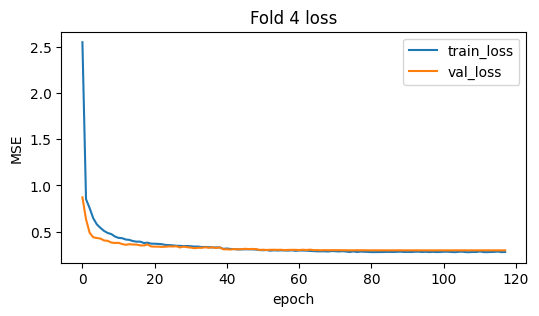


--- Fold 5/5 ---
Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0641 - mse: 4.0641

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.0569 - mse: 4.0569 - val_loss: 0.9062 - val_mse: 0.9062 - learning_rate: 0.0010
Epoch 2/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9278 - mse: 0.9278

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9247 - mse: 0.9247 - val_loss: 0.5649 - val_mse: 0.5649 - learning_rate: 0.0010
Epoch 3/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7396 - mse: 0.7396

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7391 - mse: 0.7391 - val_loss: 0.4974 - val_mse: 0.4974 - learning_rate: 0.0010
Epoch 4/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6671 - mse: 0.6671

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6664 - mse: 0.6664 - val_loss: 0.4379 - val_mse: 0.4379 - learning_rate: 0.0010
Epoch 5/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5871 - mse: 0.5871

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5872 - mse: 0.5872 - val_loss: 0.4254 - val_mse: 0.4254 - learning_rate: 0.0010
Epoch 6/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5457 - mse: 0.5457

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5461 - mse: 0.5461 - val_loss: 0.3853 - val_mse: 0.3853 - learning_rate: 0.0010
Epoch 7/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5097 - mse: 0.5097

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5098 - mse: 0.5098 - val_loss: 0.3820 - val_mse: 0.3820 - learning_rate: 0.0010
Epoch 8/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4695 - mse: 0.4695

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4697 - mse: 0.4697 - val_loss: 0.3818 - val_mse: 0.3818 - learning_rate: 0.0010
Epoch 9/200
196/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4771 - mse: 0.4771

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4769 - mse: 0.4769 - val_loss: 0.3598 - val_mse: 0.3598 - learning_rate: 0.0010
Epoch 10/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4641 - mse: 0.4641

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4637 - mse: 0.4637 - val_loss: 0.3555 - val_mse: 0.3555 - learning_rate: 0.0010
Epoch 11/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4338 - mse: 0.4338 - val_loss: 0.3569 - val_mse: 0.3569 - learning_rate: 0.0010
Epoch 12/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4206 - mse: 0.4206

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4208 - mse: 0.4208 - val_loss: 0.3456 - val_mse: 0.3456 - learning_rate: 0.0010
Epoch 13/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4093 - mse: 0.4093

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4095 - mse: 0.4095 - val_loss: 0.3360 - val_mse: 0.3360 - learning_rate: 0.0010
Epoch 14/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4012 - mse: 0.4012 - val_loss: 0.3399 - val_mse: 0.3399 - learning_rate: 0.0010
Epoch 15/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3876 - mse: 0.3876

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3880 - mse: 0.3880 - val_loss: 0.3215 - val_mse: 0.3215 - learning_rate: 0.0010
Epoch 16/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3884 - mse: 0.3884 - val_loss: 0.3258 - val_mse: 0.3258 - learning_rate: 0.0010
Epoch 17/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3839 - mse: 0.3839 - val_loss: 0.3288 - val_mse: 0.3288 - learning_rate: 0.0010
Epoch 18/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3757 - mse: 0.3757 - val_loss: 0.3323 - val_mse: 0.3323 - learning_rate: 0.0010
Epoch 19/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3734 - mse: 0.3734 - val_loss: 0.3302 - val_mse: 0.3302 - learning_rate: 0.0010
Epoch 20/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3689 - mse: 0.3689 - val_loss: 0.3248 - val_mse: 0.3248 - learning_rate: 0.0010
Epoch 21/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3686 - mse: 0.3686 - val_loss: 0.3221 - val_mse: 0.3221 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3584 - mse: 0.3584 - val_loss: 0.3198 - val_mse: 0.3198 - learning_rate: 0.0010
Epoch 23/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3614 - mse: 0.3614 - val_loss: 0.3220 - val_mse: 0.3220 - learning_rate: 0.0010
Epoch 24/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3545 - mse: 0.3545 - val_loss: 0.3208 - val_mse: 0.3208 - learning_rate: 0.0010
Epoch 25/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3465 - mse: 0.3465

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3468 - mse: 0.3468 - val_loss: 0.3103 - val_mse: 0.3103 - learning_rate: 0.0010
Epoch 26/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3546 - mse: 0.3546 - val_loss: 0.3137 - val_mse: 0.3137 - learning_rate: 0.0010
Epoch 27/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3479 - mse: 0.3479 - val_loss: 0.3180 - val_mse: 0.3180 - learning_rate: 0.0010
Epoch 28/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3426 - mse: 0.3426

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3430 - mse: 0.3430 - val_loss: 0.3088 - val_mse: 0.3088 - learning_rate: 0.0010
Epoch 29/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3421 - mse: 0.3421 - val_loss: 0.3116 - val_mse: 0.3116 - learning_rate: 0.0010
Epoch 30/200
199/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3416 - mse: 0.3416

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3417 - mse: 0.3417 - val_loss: 0.3037 - val_mse: 0.3037 - learning_rate: 0.0010
Epoch 31/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3458 - mse: 0.3458 - val_loss: 0.3075 - val_mse: 0.3075 - learning_rate: 0.0010
Epoch 32/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3397 - mse: 0.3397 - val_loss: 0.3062 - val_mse: 0.3062 - learning_rate: 0.0010
Epoch 33/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3366 - mse: 0.3366

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3366 - mse: 0.3366 - val_loss: 0.2919 - val_mse: 0.2919 - learning_rate: 0.0010
Epoch 34/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3353 - mse: 0.3353 - val_loss: 0.3005 - val_mse: 0.3005 - learning_rate: 0.0010
Epoch 35/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3265 - mse: 0.3265 - val_loss: 0.3050 - val_mse: 0.3050 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3333 - mse: 0.3333 - val_loss: 0.3018 - val_mse: 0.3018 - learning_rate: 0.0010
Epoch 37/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3279 - mse: 0.3279 - val_loss: 0.2995 - val_mse: 0.2995 - learning_rate: 0.0010
Epoch 38/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3306 - mse: 0.3306 - val_loss: 0.3086 - val_mse: 0.3086 - learning_rate: 0.0010
Epoch 39/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3263 - mse: 0.3263 - val_loss: 0.2978 - val_mse: 0.2978 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3220 - mse: 0.3220 - val_loss: 0.2896 - val_mse: 0.2896 - learning_rate: 5.0000e-04
Epoch 42/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3093 - mse: 0.3093

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3095 - mse: 0.3095 - val_loss: 0.2893 - val_mse: 0.2893 - learning_rate: 5.0000e-04
Epoch 43/200
196/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3126 - mse: 0.3126

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3125 - mse: 0.3125 - val_loss: 0.2876 - val_mse: 0.2876 - learning_rate: 5.0000e-04
Epoch 44/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3095 - mse: 0.3095 - val_loss: 0.2878 - val_mse: 0.2878 - learning_rate: 5.0000e-04
Epoch 45/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3082 - mse: 0.3082 - val_loss: 0.2913 - val_mse: 0.2913 - learning_rate: 5.0000e-04
Epoch 46/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3110 - mse: 0.3110

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3111 - mse: 0.3111 - val_loss: 0.2859 - val_mse: 0.2859 - learning_rate: 5.0000e-04
Epoch 47/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3013 - mse: 0.3013 - val_loss: 0.2893 - val_mse: 0.2893 - learning_rate: 5.0000e-04
Epoch 48/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3038 - mse: 0.3038 - val_loss: 0.2908 - val_mse: 0.2908 - learning_rate: 5.0000e-04
Epoch 49/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3089 - mse: 0.3089 - val_loss: 0.2890 - val_mse: 0.2890 - learning_rate: 5.0000e-04
Epoch 50/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3029 - mse: 0.3029 - val_loss: 0.2910 - val_mse: 0.2910 - learning_rate: 5.0000e-04
Epoch 51/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3019 - mse: 0.3019

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3021 - mse: 0.3021 - val_loss: 0.2846 - val_mse: 0.2846 - learning_rate: 5.0000e-04
Epoch 52/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3017 - mse: 0.3017 - val_loss: 0.2876 - val_mse: 0.2876 - learning_rate: 5.0000e-04
Epoch 53/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3031 - mse: 0.3031 - val_loss: 0.2855 - val_mse: 0.2855 - learning_rate: 5.0000e-04
Epoch 54/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2995 - mse: 0.2995

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2996 - mse: 0.2996 - val_loss: 0.2810 - val_mse: 0.2810 - learning_rate: 5.0000e-04
Epoch 55/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3000 - mse: 0.3000 - val_loss: 0.2851 - val_mse: 0.2851 - learning_rate: 5.0000e-04
Epoch 56/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2989 - mse: 0.2989 - val_loss: 0.2852 - val_mse: 0.2852 - learning_rate: 5.0000e-04
Epoch 57/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2994 - mse: 0.2994 - val_loss: 0.2859 - val_mse: 0.2859 - learning_rate: 5.0000e-04
Epoch 58/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3000 - mse: 0.3000 - val_loss: 0.2882 - val_mse: 0.2882 - learning_rate: 5.0000e-04
Epoch 59/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2933 - mse: 0.2933 - val_loss: 0.2848 - val_mse: 0.2848 - learning_rate: 5.0000e-04
Epoch 60/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2983 - mse: 0.2983 - val_loss: 0.2813 - val_mse: 0.2813 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2879 - mse: 0.2879 - val_loss: 0.2757 - val_mse: 0.2757 - learning_rate: 2.5000e-04
Epoch 63/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2903 - mse: 0.2903 - val_loss: 0.2773 - val_mse: 0.2773 - learning_rate: 2.5000e-04
Epoch 64/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2878 - mse: 0.2878 - val_loss: 0.2768 - val_mse: 0.2768 - learning_rate: 2.5000e-04
Epoch 65/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2829 - mse: 0.2829

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2831 - mse: 0.2831 - val_loss: 0.2753 - val_mse: 0.2753 - learning_rate: 2.5000e-04
Epoch 66/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2829 - mse: 0.2829 - val_loss: 0.2759 - val_mse: 0.2759 - learning_rate: 2.5000e-04
Epoch 67/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2830 - mse: 0.2830

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2832 - mse: 0.2832 - val_loss: 0.2725 - val_mse: 0.2725 - learning_rate: 2.5000e-04
Epoch 68/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2857 - mse: 0.2857 - val_loss: 0.2728 - val_mse: 0.2728 - learning_rate: 2.5000e-04
Epoch 69/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2812 - mse: 0.2812 - val_loss: 0.2758 - val_mse: 0.2758 - learning_rate: 2.5000e-04
Epoch 70/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2855 - mse: 0.2855 - val_loss: 0.2747 - val_mse: 0.2747 - learning_rate: 2.5000e-04
Epoch 71/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2850 - mse: 0.2850 - val_loss: 0.2767 - val_mse: 0.2767 - learning_rate: 2.5000e-04
Epoch 72/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2862 - mse: 0.2862 - val_loss: 0.2770 - val_mse: 0.2770 - learning_rate: 2.5000e-04
Epoch 73/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2843 - mse: 0.2843 - val_loss: 0.2770 - val_mse: 0.2770 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2764 - mse: 0.2764 - val_loss: 0.2725 - val_mse: 0.2725 - learning_rate: 1.2500e-04
Epoch 80/200
184/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2792 - mse: 0.2792

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2792 - mse: 0.2792 - val_loss: 0.2716 - val_mse: 0.2716 - learning_rate: 1.2500e-04
Epoch 81/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2735 - mse: 0.2735 - val_loss: 0.2718 - val_mse: 0.2718 - learning_rate: 1.2500e-04
Epoch 82/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2780 - mse: 0.2780 - val_loss: 0.2727 - val_mse: 0.2727 - learning_rate: 1.2500e-04
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2747 - mse: 0.2747 - val_loss: 0.2724 - val_mse: 0.2724 - learning_rate: 1.2500e-04
Epoch 84/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2757 - mse: 0.2757 - val_loss: 0.2728 - val_mse: 0.2728 - learning_rate: 1.2500e-04
Epoch 85/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2736 - mse: 0.2736 - val_loss: 0.2733 - val_mse: 0.2733 - learning_rate: 1.2500e-04
Epoch 86/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2755 - mse: 0.2755 - val_loss: 0.2725 - val_mse: 0.2725 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2728 - mse: 0.2728 - val_loss: 0.2711 - val_mse: 0.2711 - learning_rate: 6.2500e-05
Epoch 90/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2739 - mse: 0.2739 - val_loss: 0.2717 - val_mse: 0.2717 - learning_rate: 6.2500e-05
Epoch 91/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2763 - mse: 0.2763 - val_loss: 0.2718 - val_mse: 0.2718 - learning_rate: 6.2500e-05
Epoch 92/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2723 - mse: 0.2723 - val_loss: 0.2721 - val_mse: 0.2721 - learning_rate: 6.2500e-05
Epoch 93/200
199/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2739 - mse: 0.2739

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2739 - mse: 0.2739 - val_loss: 0.2710 - val_mse: 0.2710 - learning_rate: 6.2500e-05
Epoch 94/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2681 - mse: 0.2681 - val_loss: 0.2715 - val_mse: 0.2715 - learning_rate: 6.2500e-05
Epoch 95/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2717 - mse: 0.2717 - val_loss: 0.2719 - val_mse: 0.2719 - learning_rate: 6.2500e-05
Epoch 96/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2764 - mse: 0.2764 - val_loss: 0.2719 - val_mse: 0.2719 - learning_rate: 6.2500e-05
Epoch 97/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2729 - mse: 0.2729 - val_loss: 0.2716 - val_mse: 0.2716 - learning_rate: 6.2500e-05
Epoch 98/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2728 - mse: 0.2728 - val_loss: 0.2711 - val_mse: 0.2711 - learning_rate: 6.2500e-05
Epoch 99/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2773 - mse: 0.2773 - val_loss: 0.2715 - val_mse: 0.2715 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2729 - mse: 0.2729 - val_loss: 0.2708 - val_mse: 0.2708 - learning_rate: 3.1250e-05
Epoch 102/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2724 - mse: 0.2724 - val_loss: 0.2709 - val_mse: 0.2709 - learning_rate: 3.1250e-05
Epoch 103/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2695 - mse: 0.2695 - val_loss: 0.2713 - val_mse: 0.2713 - learning_rate: 3.1250e-05
Epoch 104/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2683 - mse: 0.2683 - val_loss: 0.2718 - val_mse: 0.2718 - learning_rate: 3.1250e-05
Epoch 105/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2714 - mse: 0.2714 - val_loss: 0.2715 - val_mse: 0.2715 - learning_rate: 3.1250e-05
Epoch 106/200
202/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2709 - mse: 0.2709

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2709 - mse: 0.2709 - val_loss: 0.2706 - val_mse: 0.2706 - learning_rate: 3.1250e-05
Epoch 107/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2700 - mse: 0.2700 - val_loss: 0.2708 - val_mse: 0.2708 - learning_rate: 3.1250e-05
Epoch 108/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2736 - mse: 0.2736

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2735 - mse: 0.2735 - val_loss: 0.2703 - val_mse: 0.2703 - learning_rate: 3.1250e-05
Epoch 109/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2725 - mse: 0.2725 - val_loss: 0.2709 - val_mse: 0.2709 - learning_rate: 3.1250e-05
Epoch 110/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2742 - mse: 0.2742 - val_loss: 0.2708 - val_mse: 0.2708 - learning_rate: 3.1250e-05
Epoch 111/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2747 - mse: 0.2747 - val_loss: 0.2711 - val_mse: 0.2711 - learning_rate: 3.1250e-05
Epoch 112/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2760 - mse: 0.2760 - val_loss: 0.2713 - val_mse: 0.2713 - learning_rate: 3.1250e-05
Epoch 113/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2704 - mse: 0.2704 - val_loss: 0.2711 - val_mse: 0.2711 - learning_rate: 3.1250e-05
Epoch 114/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2765 - mse: 0.2765 - val_loss: 0.2710 - val_mse: 0.2710

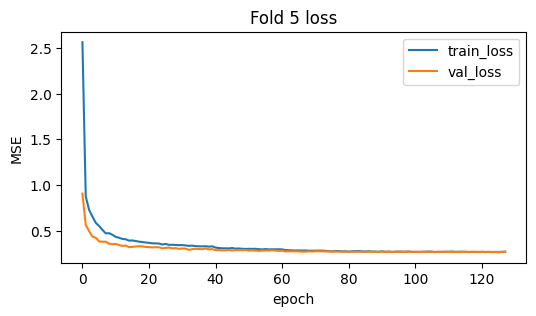


CV folds MSE per fold: [0.29217139904276196, 0.29511292673135237, 0.26636175840721976, 0.2974913814801485, 0.2703071726374519]
OOF CV MSE: 0.28429006056134065


In [25]:
# 3) Cross-validated training 

N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_train_proc))
test_preds_folds = []  # store fold predictions for ensembling
fold_metrics = []

# training hyperparams (tweakable)
BATCH_SIZE = 64
EPOCHS = 200
PATIENCE = 20
LR = 1e-3

if USE_TF:
    import tensorflow as tf
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_proc, y), 1):
        print(f"\n--- Fold {fold}/{N_FOLDS} ---")
        X_tr, X_val = X_train_proc.iloc[tr_idx].values, X_train_proc.iloc[val_idx].values
        y_tr, y_val = y[tr_idx], y[val_idx]

        # build fresh model for each fold
        model = build_keras_model(input_dim=X_tr.shape[1], hidden_units=(128,64), dropout=0.15, lr=LR)

        # callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, verbose=1, min_lr=1e-6),
        ]
        # optional: checkpoint (save best model file per fold)
        ckpt_path = os.path.join(ARTIFACT_DIR, f"keras_fold{fold}_best.h5")
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, save_weights_only=False, verbose=0))

        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1
        )

        # predict OOF & test
        val_pred = model.predict(X_val).ravel()
        oof_preds[val_idx] = val_pred
        fold_mse = mean_squared_error(y_val, val_pred)
        fold_metrics.append(fold_mse)
        print(f"Fold {fold} val MSE: {fold_mse:.6f}")

        # test preds for fold
        test_fold_pred = model.predict(X_test_proc.values).ravel()
        test_preds_folds.append(test_fold_pred)

        # plot training curve for fold (loss)
        plt.figure(figsize=(6,3))
        plt.plot(history.history["loss"], label="train_loss")
        plt.plot(history.history["val_loss"], label="val_loss")
        plt.title(f"Fold {fold} loss")
        plt.xlabel("epoch")
        plt.ylabel("MSE")
        plt.legend()
        plt.show()

    # CV summary
    oof_mse = mean_squared_error(y, oof_preds)
    print("\nCV folds MSE per fold:", fold_metrics)
    print("OOF CV MSE:", oof_mse)

    # Ensemble test preds: average across folds
    test_preds = np.mean(np.column_stack(test_preds_folds), axis=1)
else:
    # sklearn MLP fallback (single-run cross-validated)
    from sklearn.neural_network import MLPRegressor
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_proc, y), 1):
        print(f"\n--- Fold {fold}/{N_FOLDS} (sklearn MLP) ---")
        X_tr, X_val = X_train_proc.iloc[tr_idx].values, X_train_proc.iloc[val_idx].values
        y_tr, y_val = y[tr_idx], y[val_idx]

        mlp = MLPRegressor(hidden_layer_sizes=(128,64), activation="relu", solver="adam",
                           early_stopping=True, validation_fraction=0.15, n_iter_no_change=20,
                           max_iter=1000, random_state=42)
        mlp.fit(X_tr, y_tr)
        val_pred = mlp.predict(X_val)
        oof_preds[val_idx] = val_pred
        fold_mse = mean_squared_error(y_val, val_pred)
        fold_metrics.append(fold_mse)
        print(f"Fold {fold} val MSE: {fold_mse:.6f}")

        test_fold_pred = mlp.predict(X_test_proc.values)
        test_preds_folds.append(test_fold_pred)

    oof_mse = mean_squared_error(y, oof_preds)
    print("\nCV folds MSE per fold:", fold_metrics)
    print("OOF CV MSE:", oof_mse)

    test_preds = np.mean(np.column_stack(test_preds_folds), axis=1)

Saved OOF predictions: artifacts/oof_predictions.csv
Saved final submission to submission.csv


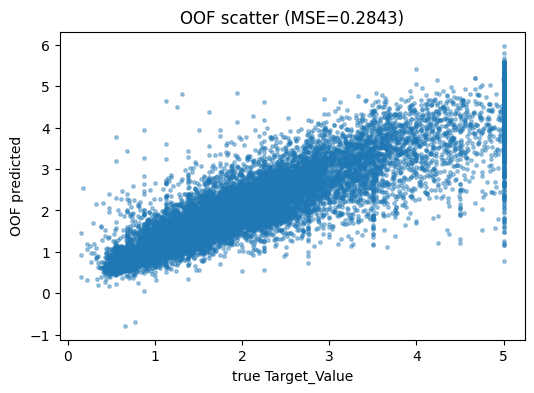

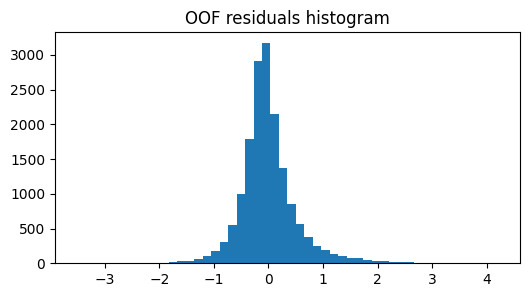

In [26]:
# 4) Save OOF, fold metrics, and submission 

# OOF dataframe
oof_df = pd.DataFrame({"ID": train_ids, "Target_Value_pred": oof_preds})
oof_df.to_csv(os.path.join(ARTIFACT_DIR, "oof_predictions.csv"), index=False)
print("Saved OOF predictions:", os.path.join(ARTIFACT_DIR, "oof_predictions.csv"))

# Fold metrics
pd.DataFrame({"fold_mse": fold_metrics}).to_csv(os.path.join(ARTIFACT_DIR, "fold_metrics.csv"), index=False)

# Final submission (average of folds)
submission = pd.DataFrame({"ID": test_ids, "Target_Value": test_preds})
submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
print("Saved final submission to", submission_path)

# Quick diagnostics plots and residual distribution
plt.figure(figsize=(6,4))
plt.scatter(y, oof_preds, alpha=0.4, s=6)
plt.xlabel("true Target_Value")
plt.ylabel("OOF predicted")
plt.title(f"OOF scatter (MSE={oof_mse:.4f})")
plt.show()

plt.figure(figsize=(6,3))
plt.hist((y - oof_preds), bins=50)
plt.title("OOF residuals histogram")
plt.show()